<h1 style='text-align: center'>Classifiers Grid Search Relative XY Concat:</h1> <br>

<h1>Introduction</h1>

In this notebook, we evaluated the performance of different classifiers for predicting the semantics of a given text as positive or negative, according to their word2vec representation as received from a given LLM model. <br>

Our goal was to find the classifier that will predict unseen examples correctly with the highest accuracy. <br>

Afterwards, we used a new data that was received from the LLM model, whose undergone a process of fine tuning, as a result the values of the LLM model parameters and their presentations have changed.

Now, we repeated the search for the best classifier and then we compared how the new data affects on our results. <br>

This notebook has 6 parts:
1. Function definitons and library imports
2. Evaluating each kind of classifiers based on <u>pretrained</u> data and choosing the best classifier for each.
3. Comparing the performance of the best classifier for each kind to choose the best classifier overall.
4. Evaluating each kind of classifiers based on <u>finetuned</u> data and choosing the best classifier for each.
5. Comparing the performance of the best classifier for each kind to choose the best classifier overall.
6. Comparing the results.

<b> After running Part 1, each part can be run separately. </b>

<a id="TOC"></a>
<h1>Table of Contents:</h1><br>

1. [Part 1 - Functions definitons and libraries imports](#Part1)
2. [Part 2 - Evaluate Classifiers on Pretrained Dataset](#Part2) <br>
    2.1.1. [KNN](#KNN) <br>
    2.1.2. [KNN Conclusion](#KNN_Conclusion) <br>
    2.2.1 [QDA](#QDA) <br>
    2.2.2 [QDA Conclusion](#QDA_Conclusion) <br>
    2.3.1 [LDA](#LDA) <br>
    2.3.2 [LDA Conclusion](#LDA_Conclusion) <br>
    2.4.1 [GNB](#GNB) <br>
    2.4.2 [GNB Conclusion](#GNB_Conclusion) <br>
    2.5.1 [Decision Tree](#Decision_Tree) <br>
    2.5.2 [Decision Tree Conclusion](#Decision_Tree_Conclusion) <br>
    2.6.1 [Random Forest](#Random_Forest) <br>
    2.6.2 [Random Forest Conclusion](#Random_Forest_Conclusion) <br>
3. [Part 3 - Classifiers Comparison](#Part3)

<a id="Part1"></a>
<h1 style='text-align: center'><u style='background-color:rgb(0,255,128)'>Part 1: Functions definitons and libraries imports</u></h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

<h4>Libraries imports</h4>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.preprocessing import StandardScaler
from time import time
from matplotlib.patches import Patch
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<h4>Functions definitions</h4>

<h4>Classifier Evaluator</h4><br>
This function will be used to evaluate the performance of a classifier according to the following principles: <br>

1. Train Test splits, with test size of 0.2 and train size of 0.8, because we prefered that the train size will be large enough, while having a suitable size for the test.<br>

2. Using Cross Validation to validate the accuracy of the result, we used CV=5, in order to keep inside the folding the train-test portions. <br>

3. We used Grid Search in order to find the optimal parameters combinations that fits the classifier to have the highest accuracy, given a parameter grid to search through. <br>

4. We used two score metrics to evaluate the classifier, accuracy and f1. The classifier was refitted according to the accuracy while f1 was used for confirm the accuracy credability.

In [3]:
def eval_classifier(base_estimator, param_grid, X_train, X_test, y_train, y_test, target_names, test_size, random_state, n_jobs, is_printing=['best', 'report', 'plot', 'time']):
    """
        Input - base_estimator- Classifier model
                param_grid- The model's hyperparameters to be evaluated
                X- Data Features
                Y- Data Labels
                target_names- Label Names
                test_size- The portion of the dataset to be divided into a test dataset
                random_state-  The random state of data spliting
                n_jobs- The number of processes that run in parallel
                is_printing- Controls which kind of prints to show, from the list of: ['best', 'report', 'plot', 'time']
        Output - The results table with each combination of the param grid
                 The best estimator
                 The fitted classifier
        Description - Evaluating the given classifier model by using Grid Search with scoring of accuracy and f1 metrics.
                      Print of Table of top 5 estimators according to f1 metric
                      Print of The best estimator
                      Print of The Classification report that contains the metrics: precision, recall, f1 and accuracy
                      Print of The Confusion Matrix
    """
    # the parameters list the Grid Search uses
    prefix = "param_"
    param_list = [prefix + key for key in param_grid.keys()]
    
    # the columns results of the Grid Search
    columns = param_list + ["mean_fit_time",
                            "std_fit_time",
                                         "mean_test_accuracy",
                                         "std_test_accuracy",
                                         "rank_test_accuracy"]            
        
    # define the scoring metrics    
    #scoring = {'accuracy': 'accuracy', 'f1': 'f1'}
    
    # define the grid search instance
    clf = GridSearchCV(base_estimator, param_grid, cv=5, scoring=['accuracy'], refit='accuracy', n_jobs=n_jobs, verbose=10)
    #clf = GridSearchCV(base_estimator, param_grid, cv=5, n_jobs=n_jobs)
    
    # fit the classifier
    t = time()
    clf.fit(X_train, y_train)
    elapsed = time() - t
    
    # save the best classifier
    best_estimator = clf.best_estimator_  
    
    # save the results of the grid search
    results_df = pd.DataFrame(clf.cv_results_)
    
    # save the top 5 rankings according to accuracy and sort them by it
    results_df_top = results_df.loc[results_df["rank_test_accuracy"] <= 5, columns]
    results_df_top.sort_values(by=['rank_test_accuracy'], inplace=True)
    
    # print the best classifier
    if 'best' in is_printing:
        display(results_df_top)
    
        print("Best Estimator is: " + str(best_estimator) + "\n")
    
    # print the classification report and the confusion matrix
    if 'report' in is_printing:
        y_pred = best_estimator.predict(X_test)

        confMat = confusion_matrix(y_test, y_pred)
        confMat_df = pd.DataFrame(confMat, index=target_names, columns=target_names)
        print("The Confusion Matrix:")
        display(confMat_df)  
        print("\n")

        report = classification_report(y_test, y_pred, target_names=target_names)
        print("The Classification Report:")
        print(report)
        print("\n")
      
    # plot the accuracy vs the max result of each parameter
    if 'plot' in is_printing:        
        for param in param_list:
            param_key = list(param_grid.keys())[param_list.index(param)]
            
            if(len(param_grid[param_key])>1):
                plot_param(results_df, param)
    
    # print the time it took to fit
    if 'time' in is_printing:                        
        print("Elapsed Fit Time: " + str(elapsed) + " [s]")
    
    return [results_df, best_estimator, clf]

<h4>Plot Parameter</h4><br>
This function will be used to represent the results of the given parameter in a plot

In [4]:
def plot_param(results_df, param):
    """
        Input - results_df- The results table that contains the param
        Output - None
        Description - Plots the max accuracy vs the param        
    """
    # sort the table according to the given param in ascending order
    param_df = results_df.replace(np.nan, 'None').sort_values(by=[param])
    
    param_df_max = param_df.groupby(param, dropna=False).max()[['mean_test_accuracy']]
    
    # find the max accuracy overall
    max_x = param_df_max.idxmax()
    max_y = param_df_max.max()
    
    # check if the parameter has numbers, in order to decide between plot or bar
    is_numbers = all([str(s).isdigit() for s in results_df[param].tolist()])
    
    # plot the data
    if is_numbers:    
        plt.plot(param_df_max)
        plt.plot(max_x, max_y, 'ro', label=f'({max_x[0]},{round(max_y[0],2)})')
        plt.legend(loc='best')
    else:
        # in order to display None in the bar
        max_x_index = np.argmax(param_df_max)    
        
        # mark the max bar
        bars = param_df_max.plot.bar(rot=0)                
        min_val = param_df_max.min().values
        max_val = param_df_max.max().values
        delta_val = max_val-min_val
        if delta_val != 0:
            bars.set_ylim([min_val - delta_val,max_val + delta_val])
        
        max_bar = bars.patches[max_x_index]
        max_bar.set_facecolor('red')
        plt.gca().get_legend().remove()            
    
    plt.xlabel(param)
    plt.ylabel("max mean_test_accuracy")
    plt.title("max mean_test_accuracy VS " + param)
    
    plt.show()

<h4>Best Classifier Evaluator</h4><br>
This function will be used to validate the results of the best classifier after each Exhaustive Search

In [5]:
def eval_best(best_estimator, base_estimator, X_train, X_test, y_train, y_test, Labels, n_jobs):
    """
    Input - 
            best_estimator- the classifier to be evaluated
            base_estimator- the model of the classifier
            X- Data Features
            Y- Data Labels   
            Labels- Label Names 
            n_jobs- The number of processes that run in parallel
    Output - 
            None
    Description - 
            Plots the score results of the evaluated classifier for different random_states and test sizes,
            in order to validate the results, and ensure stability for future unseen examples
    """
    
    # create the parameter grid, which are the parameters that the best classifier was fitted on
    param_grid = {}
    for param in best_estimator.get_params().keys():
        param_grid[param] = [best_estimator.get_params()[param]]

    # the range of the random_states to check on
    random_state_vec = np.arange(30)
    
    # init result vectors and dataframe
    results_df_02_i = []
    results_df_03_i = []
    results_df_04_i = []
    results_df_all = pd.DataFrame()
    
    # for each random_state, evaluate the classifier in different test sizes and add the accuracy result to the vector
    for i in random_state_vec:
        [results_df,_,_] = eval_classifier(base_estimator, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=i, n_jobs=n_jobs, is_printing=[])
        results_df_02_i.append(results_df['mean_test_accuracy'].values[0])

        [results_df,_,_] = eval_classifier(base_estimator, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.3, random_state=i, n_jobs=n_jobs, is_printing=[])
        results_df_03_i.append(results_df['mean_test_accuracy'].values[0])

        [results_df,_,_] = eval_classifier(base_estimator, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.4, random_state=i, n_jobs=n_jobs, is_printing=[])
        results_df_04_i.append(results_df['mean_test_accuracy'].values[0])        
    
    # plot the results
    plt.plot(random_state_vec, results_df_02_i, label='test size = 0.2, mean=' + str(round(np.mean(results_df_02_i),3)) + ', std=' + str(round(np.std(results_df_02_i),3)))
    plt.plot(random_state_vec, results_df_03_i, label='test size = 0.3, mean=' + str(round(np.mean(results_df_03_i),3)) + ', std=' + str(round(np.std(results_df_03_i),3)))
    plt.plot(random_state_vec, results_df_04_i, label='test size = 0.4, mean=' + str(round(np.mean(results_df_04_i),3)) + ', std=' + str(round(np.std(results_df_04_i),3)))
    plt.ylim(0, 1)
    plt.title("Evaluation of the Best Classifier: " + str(best_estimator))
    plt.xlabel('random_state')
    plt.ylabel('mean_test_accuracy')
    plt.legend()        

<a id="Part2"></a>
<h1 style='text-align: center'><u style='background-color:rgb(0,255,128)'>Part 2: Evaluate Classifiers on Pretrained Dataset</u></h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

In this part, using the pretrained dataset, we evaluated seperately each from the following classifiers: KNN, QDA, LDA, GNB, Decision Tree, Random Forest. <br>
* Firstly, for each classifier we examined each of his parameters seperately, in order to find the range of their optimal values.<br>
* Secondly, we performed an Exhaustive Search for each classifier which evaluated each combination of the optimal parameters we found, in order to find the best classifier.<br>
* Finally, for each classifier, we chose the best parameters combinations that bring the best classifier in terms of accuracy.

Note: We understand that there could be combinations of parameters that we didn't check, however, due to runtime and resources limitations, we chose to examine the combinations of the best we found.

<h4>Loading the pretrained data and prepare it for the classifier</h4>

In [10]:
YTrainLabels = np.ravel(pd.read_csv("../datasets/landmarks/landmarks_relative_480x480_XY_Concat_labels_train.csv"))
X_train = pd.read_csv("../datasets/landmarks/landmarks_relative_480x480_XY_Concat_features_train.csv").values

Labels, y_train = np.unique(YTrainLabels, return_inverse=True)

YTestLabels = np.ravel(pd.read_csv("../datasets/landmarks/landmarks_relative_480x480_XY_Concat_labels_test.csv"))
X_test = pd.read_csv("../datasets/landmarks/landmarks_relative_480x480_XY_Concat_features_test.csv").values

Labels, y_test = np.unique(YTestLabels, return_inverse=True)

In [7]:
with open('models/classifiers/relative_XY_Concat/scaler.pkl', 'rb') as f:
   scaler = pickle.load(f)

In [8]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_train.shape

(18851, 136)

In [10]:
Labels

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [11]:
y_train.shape

(18851,)

In [12]:
X_test.shape

(4691, 136)

In [13]:
y_test.shape

(4691,)

Shuffle the data

In [14]:
np.random.seed(10)
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]

Take only part of the data

In [15]:
N_train = len(X_train)#5000
N_test = len(X_test)#1000
X_train, y_train = X_train[:N_train], y_train[:N_train]
X_test, y_test = X_test[:N_test], y_test[:N_test]

In [16]:
X_train.shape

(18851, 136)

In [17]:
Labels

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [18]:
y_train.shape

(18851,)

In [19]:
X_test.shape

(4691, 136)

In [20]:
y_test.shape

(4691,)

In [21]:
unique_train_data, counts_train_data = np.unique(y_train, return_counts=True)
print('Train Data Histogram')
print(np.asarray((unique_train_data, counts_train_data)).T)

Train Data Histogram
[[   0 2579]
 [   1  325]
 [   2 2357]
 [   3 5324]
 [   4 3547]
 [   5 2564]
 [   6 2155]]


In [22]:
unique_test_data, counts_test_data = np.unique(y_test, return_counts=True)
print('Test Data Histogram')
print(np.asarray((unique_test_data, counts_test_data)).T)

Test Data Histogram
[[   0  614]
 [   1   80]
 [   2  618]
 [   3 1313]
 [   4  874]
 [   5  637]
 [   6  555]]


<h4>Number of CPUs to use</h4>

In [23]:
# number of CPUs to use, -1 means all CPUs available
n_jobs=20

<a id="KNN"></a>
<h1>KNN</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

K-Nearest Neighbors (KNN) algorithm is a method used for classification, where an unlabeled data point is classified based on the majority class of its k nearest neighbors in the feature space. It operates by measuring distances between data points in a multi-dimensional space.

In [23]:
# start timer for full classifier evaluation run
t_classifier = time()

<h3>Parameters of the KNN Classifier:</h3>

In [43]:
from sklearn.neighbors import KNeighborsClassifier

base_estimator_KNN = KNeighborsClassifier()
base_estimator_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

<h4>The params are:</h4>
1. n_neighbors <br>
2. weights <br>
3. algorithm <br>
4. leaf_size <br>
5. p <br>
6. metric <br>
7. metric_params <br>
8. n_jobs <br>

<b>1. n_neighbors</b><br>
The parameter n_neighbors is the number of K neighbors used in the KNN algorithm. <br>
The n_neighbors is a postivie integer, usually a small number, the default is 5. <br><br>
In our run, we have 5816 examples in total, which are divieded into train and test datasets. <br>
We will check a range of n_neighbors values, with taking into consideration the size of our dataset.<br>
The range we decided on is from 1 to 100 in steps of 1, and then from 100 to 500 in steps of 11.

Fitting 5 folds for each of 136 candidates, totalling 680 fits


,param_n_neighbors,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
19,20,0.053376,0.004752,0.449685,0.003821,1
21,22,0.050533,0.011363,0.449684,0.004793,2
20,21,0.071347,0.023936,0.449579,0.005157,3
22,23,0.055169,0.006629,0.449525,0.004209,4
24,25,0.061016,0.011367,0.449154,0.003454,5


Best Estimator is: KNeighborsClassifier(n_neighbors=20)



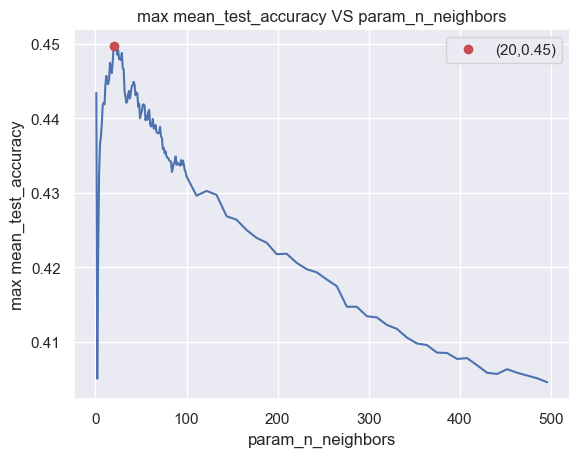

Elapsed Fit Time: 216.96126461029053 [s]


In [44]:
param_grid = {
    'n_neighbors': np.arange(1,100).tolist() + np.arange(100,500,11).tolist()
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
For this test, the number of n_neighbors that gave the best performance, is 31. <br>
According to the table we can see, that all of the top 5 runs gave almost the same accuracy and f1 score. <br>
As we can see, when choosing n_neighbors we will aim for an odd numbers of n_neighbors, as shown in the table and the plot (alternating rise and fall). <br>
A high value of k value could lead to lose the effect and the significance of <u>close</u> neighbors, and a small value of k could lead to losing the majority vote effect.
The value of k is dependent on the number of examples trained.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [45]:
random_state_vec = np.arange(30)
n_neighbors_vec = []
param_grid = {
    'n_neighbors': [26, 25, 24, 23, 27],
}
for random_state in random_state_vec:

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=random_state, n_jobs=n_jobs, is_printing=[])
    n_neighbors_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_n_neighbors'].values[0])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates

Text(0, 0.5, 'best n_neighbors')

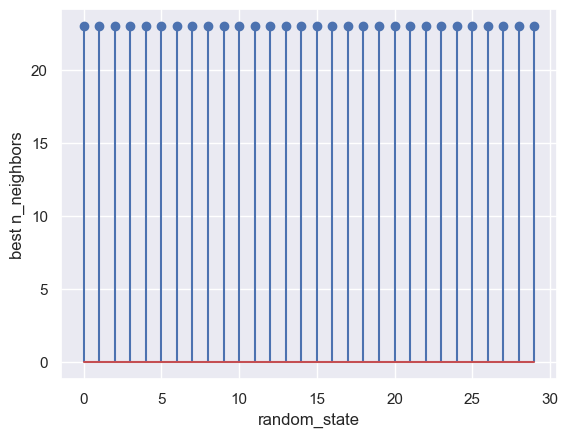

In [46]:
plt.stem(random_state_vec, n_neighbors_vec)
plt.xlabel('random_state')
plt.ylabel('best n_neighbors')

In [47]:
# best values of the feature and their frequency
unique, counts = np.unique(n_neighbors_vec, return_counts=True)
print(np.asarray((unique, counts)).T)

[[23 30]]


<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see after the validation, the best n_neighbors_vec varies. <br>
In the Exhaustive Search, we will choose 31.

<b>2. weights</b><br>
Weight function, determines the influence of neighboring datapoints in the prediction process. <br>
Possible values:
* Uniform- Equal weight to all neighbors.
* Distance- More weight to closer neighbors, by the inverse of their distance.

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,param_weights,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
1,distance,0.030808,0.002787,0.472495,0.003676,1
0,uniform,0.029008,0.002452,0.436529,0.007471,2
2,None,0.027207,0.002927,0.436529,0.007471,2


Best Estimator is: KNeighborsClassifier(weights='distance')



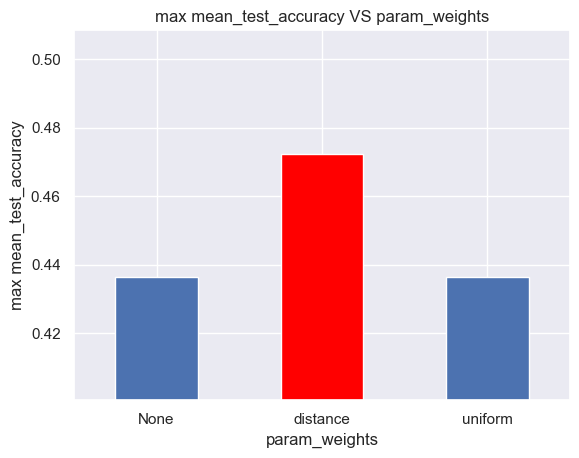

Elapsed Fit Time: 4.904994964599609 [s]


In [48]:
param_grid = {
    'weights': ['uniform', 'distance', None]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
For this test, the weight that gave the best performance, is 'distance'. <br>
It should be note that the gap between the different weights is insignificant. <br>

<u>Validation</u>:<br>
We will iterate through 100 different random_states, in order to validate the results we got above.

In [49]:
param_grid = {
    'weights': ['uniform', 'distance', None]
}

random_state_vec = np.arange(30)
acc_uniform_vec = []
acc_distance_vec = []
acc_none_vec = []
for random_state in random_state_vec:
    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=random_state, n_jobs=n_jobs, is_printing=[])
    acc_uniform_vec.append(results_df[results_df['param_weights']=='uniform']['mean_test_accuracy'].values[0])
    acc_distance_vec.append(results_df[results_df['param_weights']=='distance']['mean_test_accuracy'].values[0])
    acc_none_vec.append(results_df[results_df['param_weights'].isnull()]['mean_test_accuracy'].values[0])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates

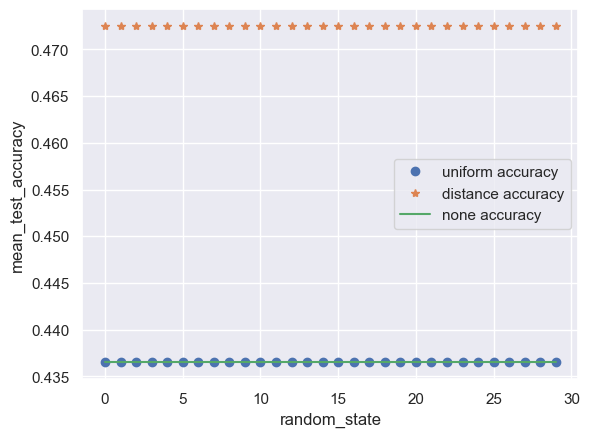

In [50]:
# plot both of the runs
plt.plot(random_state_vec, acc_uniform_vec, 'o', label='uniform accuracy')
plt.plot(random_state_vec, acc_distance_vec, '*', label='distance accuracy')
plt.plot(random_state_vec, acc_none_vec, label='none accuracy')
plt.xlabel('random_state')
plt.ylabel('mean_test_accuracy')
plt.legend()

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the weight parameter gave the similar result for all the values. <br>
In the Exhaustive Search, we will include all of them.

<b>3. algorithm</b><br>
The algorithm used to compute the nearest neighbors.
The possible values:
* ‘ball_tree’ will use BallTree
* ‘kd_tree’ will use KDTree
* ‘brute’ will use a brute-force search.
* ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,param_algorithm,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
1,ball_tree,0.797959,0.046193,0.436582,0.007446,1
2,kd_tree,1.083223,0.046775,0.436582,0.007446,1
0,auto,0.045668,0.010068,0.436529,0.007471,3
3,brute,0.037058,0.003163,0.436529,0.007471,3


Best Estimator is: KNeighborsClassifier(algorithm='ball_tree')



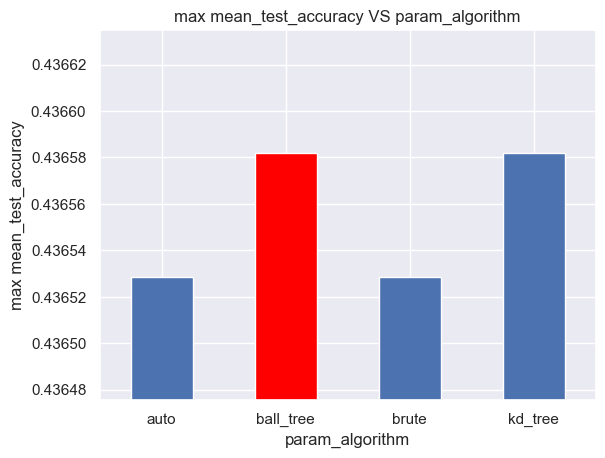

Elapsed Fit Time: 18.463412284851074 [s]


In [51]:
param_grid = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
For this test, the algorithm that gave the best performance, is 'auto'. <br>
It should be noted that the we infer from the graph, that for this dataset, the auto algorithm which was used is the brute algorithm. <br>
We also see that the auto / 'brute' algorithms were the fastest to fit. <br>

<u>Validation</u>:<br>
We will iterate through 100 different random_states, in order to validate the results we got above.

In [52]:
param_grid = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

random_state_vec = np.arange(30)
acc_auto_vec = []
acc_ball_tree_vec = []
acc_kd_tree_vec = []
acc_brute_vec = []
for random_state in random_state_vec:
    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=random_state, n_jobs=n_jobs, is_printing=[])
    acc_auto_vec.append(results_df[results_df['param_algorithm']=='auto']['mean_test_accuracy'].values[0])
    acc_ball_tree_vec.append(results_df[results_df['param_algorithm']=='ball_tree']['mean_test_accuracy'].values[0])
    acc_kd_tree_vec.append(results_df[results_df['param_algorithm']=='kd_tree']['mean_test_accuracy'].values[0])
    acc_brute_vec.append(results_df[results_df['param_algorithm']=='brute']['mean_test_accuracy'].values[0])    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates

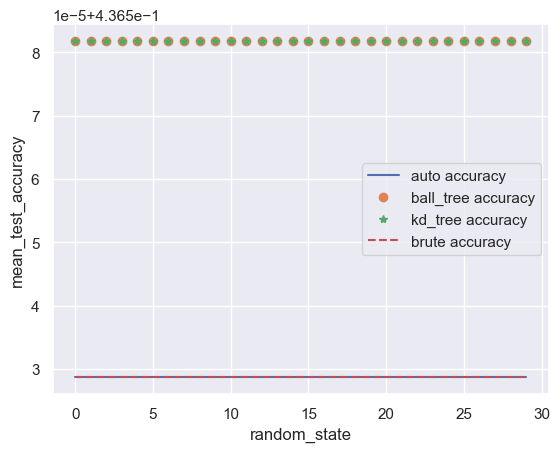

In [53]:
# plot both of the runs
plt.plot(random_state_vec, acc_auto_vec, label='auto accuracy')
plt.plot(random_state_vec, acc_ball_tree_vec, 'o', label='ball_tree accuracy')
plt.plot(random_state_vec, acc_kd_tree_vec, '*', label='kd_tree accuracy')
plt.plot(random_state_vec, acc_brute_vec, '--', label='brute accuracy')
plt.xlabel('random_state')
plt.ylabel('mean_test_accuracy')
plt.legend()

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the weight algorithm gave similar result for all the values. <br>
In the Exhaustive Search, we will include ['brute', 'kd_tree', 'ball_tree'] (we discard 'auto' as it decides between those algorithms).

<b>4. leaf_size</b><br>
When using BallTree or KDTree algorithms to compute the nearest neighbors, we need to pass the leaf size of the tree, which can affect the algorithm.
default value = int(30)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


,param_algorithm,param_leaf_size,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,ball_tree,1,0.623352,0.007994,0.436582,0.007446,1
138,kd_tree,40,0.721200,0.008293,0.436582,0.007446,1
139,kd_tree,41,0.760117,0.028569,0.436582,0.007446,1
140,kd_tree,42,0.747846,0.049077,0.436582,0.007446,1
141,kd_tree,43,0.715550,0.022362,0.436582,0.007446,1
...,...,...,...,...,...,...,...
66,ball_tree,67,0.540049,0.065284,0.436582,0.007446,1
67,ball_tree,68,0.538480,0.030656,0.436582,0.007446,1
68,ball_tree,69,0.490143,0.028189,0.436582,0.007446,1
70,ball_tree,71,0.465317,0.012364,0.436582,0.007446,1


Best Estimator is: KNeighborsClassifier(algorithm='ball_tree', leaf_size=1)



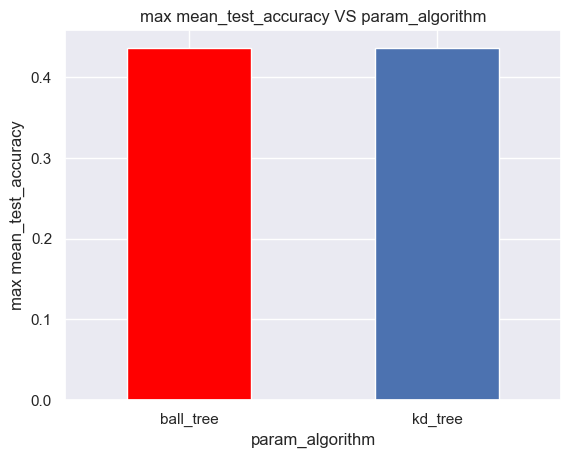

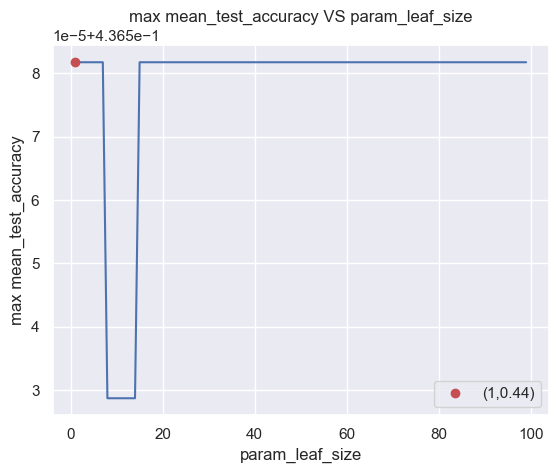

Elapsed Fit Time: 1568.793817281723 [s]


In [54]:
param_grid = {
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': np.arange(1,100)
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
When examining the number of optimal leaf_size, we need to measure it according to the tree algorithm we are using. <br>
According the bar graph, it seems there is no significant difference between the algorithms as a parameter of the leaf_size, additionally, there is a wide range of leaf_size that give the same or similar results. <br>
Therefore, for our problem we can use our default value 30.

<b>5. p</b><br>
KNN is based on distance measurement between neighbors. <br>
The distance is calculated using Minkowski metric. <br>
p is the Power parameter for the Minkowski metric.<br>
When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.<br>
For arbitrary p, minkowski_distance is used. This parameter is expected to be positive. default value is 2, which means euclidean_distance.

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,param_p,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
2,1.5,0.041718,0.007454,0.436635,0.005689,1
4,2,0.014407,0.003392,0.436529,0.007471,2
3,1.7,0.032523,0.003901,0.435839,0.006826,3
1,1.3,0.048334,0.018576,0.435679,0.007260,4
0,1,0.057629,0.021236,0.434619,0.003466,5


Best Estimator is: KNeighborsClassifier(p=1.5)



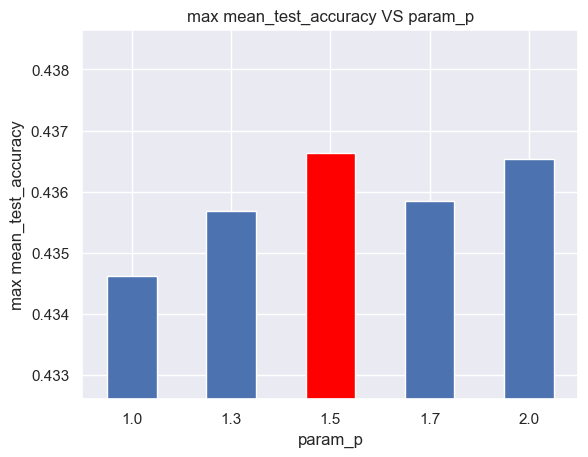

Elapsed Fit Time: 612.9074499607086 [s]


In [55]:
param_grid = {
    'p': [1, 1.3, 1.5, 1.7, 2]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
When examining the number of optimal p, the default value 2, which is using euclidean_distance, gave the best performance. <br>

<u>Validation</u>:<br>
We will iterate through 30 different random_states, in order to validate the results we got above.

In [56]:
random_state_vec = np.arange(30)
p_vec = []
param_grid = {
    'p': [1, 1.3, 1.5, 1.7, 2],
}
for random_state in random_state_vec:

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=random_state, n_jobs=n_jobs, is_printing=[])
    p_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_p'].values[0])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
plt.stem(random_state_vec, p_vec)
plt.xlabel('random_state')
plt.ylabel('best p')

In [ ]:
# best values of the feature and their frequency
unique, counts = np.unique(p_vec, return_counts=True)
print(np.asarray((unique, counts)).T)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
When examining the number of optimal p, we see it varies. <br>
Therefore, in the Exhaustive Search we will choose [1, 1.3, 2].

<b>6. metric</b><br>

As explaiend in the previous p parameter, the metric that we will use is the default 'minkowski'

<b>7. metric_params</b><br>

In our project, we will not dive into this parameter.

<b>8. n_jobs</b><br>

The number of parallel jobs to run for neighbors search. doesn't affect the accuracy, only the speed of the search, therefore can affect the overall fit time.

<h3>Exhaustive Search:</h3>

In [57]:
param_grid = {
    'n_neighbors': [20, 21, 22, 23, 24, 25],#+np.arange(200,1000+200,200).tolist(),
    'weights': ['uniform', 'distance'],
    'algorithm': ['brute', 'ball_tree', 'kd_tree'],
    'leaf_size': [1, 40, 100],
    'p': [1, 1.5, 2]
}

[results_df_KNN, best_estimator_KNN, clf_fitted_KNN] = eval_classifier(base_estimator_KNN, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,param_n_neighbors,param_weights,param_algorithm,param_leaf_size,param_p,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
35,25,distance,brute,1,2,0.015003,0.002191,0.494298,0.002118,1
71,25,distance,brute,40,2,0.021204,0.006210,0.494298,0.002118,1
107,25,distance,brute,100,2,0.016804,0.005777,0.494298,0.002118,1
143,25,distance,ball_tree,1,2,0.480507,0.009543,0.494298,0.002118,1
179,25,distance,ball_tree,40,2,0.328874,0.014989,0.494298,0.002118,1
215,25,distance,ball_tree,100,2,0.301068,0.004606,0.494298,0.002118,1
251,25,distance,kd_tree,1,2,0.886800,0.008847,0.494298,0.002118,1
287,25,distance,kd_tree,40,2,0.562552,0.016797,0.494298,0.002118,1
323,25,distance,kd_tree,100,2,0.499712,0.015708,0.494298,0.002118,1


Best Estimator is: KNeighborsClassifier(algorithm='brute', leaf_size=1, n_neighbors=25,
                     weights='distance')

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,123,1,39,189,196,40,26
disgust,4,28,2,18,20,6,2
fear,56,1,112,139,197,49,64
happy,29,3,21,1067,145,22,26
neutral,38,2,26,197,541,55,15
sad,44,0,34,180,264,101,14
surprise,15,1,23,72,88,16,340




The Classification Report:
              precision    recall  f1-score   support

       angry       0.40      0.20      0.27       614
     disgust       0.78      0.35      0.48        80
        fear       0.44      0.18      0.26       618
       happy       0.57      0.81      0.67      1313
     neutral       0.37      0.62      0.47       874
         sad       0.35      0.16      0.22       637
    surprise       0.70      0.61      0.65       555

    accuracy                           0.49      4691
   macro avg       0.52      0.42      0.43      4691
weighted avg       0.48      0.49      0.46      4691



Elapsed Fit Time: 9540.567857980728 [s]


<h3><u style='background-color:yellow'>Conclusion:</u></h3>
In this part, we conduct Exhaustive Search on the parameters that gave good indications about the ranges we need to check more specifically. <br>
As a result, we get that the best estimator: KNeighborsClassifier(algorithm='ball_tree', leaf_size=60, n_neighbors=63,
                     weights='distance'). <br>
Acording to the best estimator, we validate the result by evaluating the model with different dataset divisions (random_state) and with different test sizes.

In [ ]:
eval_best(best_estimator_KNN, base_estimator_KNN, X_train, X_test, y_train, y_test, Labels, n_jobs)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
In order to make sure that our decision decided optimal classifier does represent well the true optimal classifier, so we conducted model validation by testing the best classifier on different test and train dataset divisions (test_size), and on different dataset shuffles (random_state). <br>
As we can see, the model validation is stable.

In [ ]:
# end timer for full classifier evaluation run
elapsed_classifier = time() - t_classifier
print("Elapsed Full Classifier Evaluation Time: " + str(elapsed_classifier) + " [s]")

<a id="KNN_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>KNN Overall Conclusion:</u></h2><br>
In this section, we tested the performance of KNN algorithm on our dataset. <br>
After evaluating each parameter separately, we performed Exhaustive Search and infered from it the best classifier which is KNeighborsClassifier(algorithm='ball_tree', leaf_size=60, n_neighbors=63, weights='distance'). that gives us an accuracy of 0.74 and f1 scores of 0.77 for negative and 0.71 for positive.<br>

<a id="QDA"></a>
<h1>QDA</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

Quadratic Discriminant Analysis is a classification algorithm that uses a quadratric decision surface to separate between classes.<br>
This classifier calculates the probability of new data being part of a certain class using Bayes’ rule.<br>
The model fits a Gaussian density to each class, as it assumes that the measurements from each class are normally distributed.

In [24]:
# start timer for full classifier evaluation run
t_classifier = time()

<h3>Parameters of the QDA Classifier:</h3>

In [25]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

base_estimator_QDA = QuadraticDiscriminantAnalysis()
base_estimator_QDA.get_params()

{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'tol': 0.0001}

<h4>The params are:</h4>
1. priors <br>
2. reg_param <br>
3. store_covariance <br>
4. tol <br>

<b>1. priors</b><br>

Prior probabilities of a class is the probability that a randomly chosen example belongs to that class, which is also known as $\pi_c$. <br>
By default, the class proportions are inferred from the training data.
In our case, because the data is imbalanced while also is multiclass, we take the default class priors that are infered from the training data.
Because we use StratifiedKFold which preserves the data division, we can still infer the priors from the training data.

In [ ]:
# checking model performance for different priors probabilities 
# None is the default prior
'''
priors_list = [None]
for prior in np.arange(0.01,1,0.01):
    priors_list.append(np.array([prior,1-prior]))
    
param_grid = {
    'priors': priors_list
}

# 
[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_QDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'time'])
'''

<b>2. reg_param</b><br>

The reg_param parameter sets the regularization applied to the covariance matrices estimated for each class. Covariance matrices capture the relationships between features within a class. <br>
The optimal value for reg_param depends on the dataset.
If the dataset has a high number of features compared to training examples, a higher reg_param value can help in avoiding overfitting, otherwise, a lower reg_param value should be used.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_reg_param,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.0,0.343066,0.049879,0.578909,0.006207,1
1,0.05,0.380100,0.050398,0.558856,0.006121,2
2,0.1,0.385234,0.048179,0.550050,0.007566,3
3,0.15,0.365299,0.044240,0.543366,0.007464,4
4,0.2,0.313899,0.085701,0.538274,0.005314,5


Best Estimator is: QuadraticDiscriminantAnalysis()



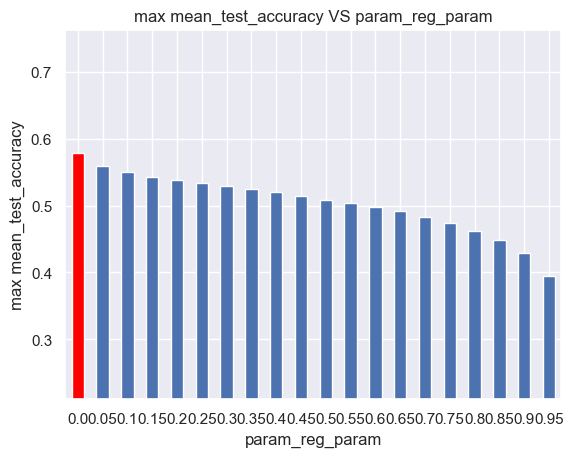

Elapsed Fit Time: 5.787081956863403 [s]


In [28]:
# checking model performance for reg params
    
param_grid = {
    'reg_param': np.round(np.arange(0.0,1.0,0.05),2)
}

# 
[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_QDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
We can see that we received an optimal reg_param value of 0. <br>
As we explained, this could mean that the number of examples in the dataset is suits the number of features. <br>
Therefore, there is no concern for overfitting.

<b>3. store_covariance</b><br>

If True, the class covariance matrices are explicitly computed and stored in the self.covariance_ attribute. <br>
Therefore, the store_covariance parameter doesn't affect the accuracy of the classifier.

<b>4. tol</b><br>

Absolute threshold for a singular value to be considered significant. <br>
This parameter does not affect the predictions. It only controls a warning that is raised when features are considered to be colinear. <br>
Therefore, the tol parameter doesn't affect the accuracy of the classifier.

<h3>Exhaustive Search:</h3>

In [ ]:
'''
param_grid = {
    'priors': [np.array([0.39, 0.61]), real_prior, None]
}

random_state_vec = np.arange(300)
results_df_i = pd.DataFrame()
for i in random_state_vec:
    [results_df,_,_] = eval_classifier(base_estimator_QDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=i, n_jobs=n_jobs, is_printing=[])
    results_df_i = results_df_i.append(results_df.sort_values(by='rank_test_accuracy').iloc[[0]])
'''    

In [ ]:
# end timer for full classifier evaluation run
elapsed_classifier = time() - t_classifier
print("Elapsed Full Classifier Evaluation Time: " + str(elapsed_classifier) + " [s]")

<a id="QDA_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>QDA Overall Conclusion:</u></h2><br>
In this section, we tested the performance of QDA algorithm on our dataset. <br>
After going over possible parameters of the classifier, we didn't find a hyper-parameter which could be useful for us. <br>
Thus, the default QDA classifier is the one we will use.

<a id="LDA"></a>
<h1>LDA</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

LDA is a special case of QDA, where the Gaussians for each class are assumed to share the same covariance matrix: $\Sigma_1=\Sigma_2=...=\Sigma_c=\Sigma$ <br>
Linear Discriminant Analysis can be used to perform supervised dimensionality reduction.

In [29]:
# start timer for full classifier evaluation run
t_classifier = time()

<h3>Params Search:</h3>

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

base_estimator_LDA = LinearDiscriminantAnalysis()
base_estimator_LDA.get_params()

{'covariance_estimator': None,
 'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

<h4>The params are:</h4>
1. solver <br>
2. shrinkage <br>
3. priors <br>
4. n_components <br>
5. store_covariance<br>
6. tol <br>
7. covariance_estimator <br>

<b>1. solver</b><br>
The solver parameter determines the algorithm used to find the optimal separation between classes.<br>
The possible values are:
* ‘svd’: Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.

* ‘lsqr’: Least squares solution. Can be combined with shrinkage or custom covariance estimator.

* ‘eigen’: Eigenvalue decomposition. Can be combined with shrinkage or custom covariance estimator.

In [31]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best','time'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,param_solver,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,svd,0.482200,0.023711,0.563684,0.002069,1
1,lsqr,0.163646,0.007119,0.563631,0.002010,2
2,eigen,0.216545,0.002638,0.563631,0.002010,2


Best Estimator is: LinearDiscriminantAnalysis()

Elapsed Fit Time: 0.9015374183654785 [s]


<h3><u style='background-color:yellow'>Conclusion:</u></h3>
solver has no effect for this run, its best set to the default 'svd'.

<u>Validation</u>:<br>
We will iterate through 100 different random_states, in order to validate the results we got above.

In [32]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']
}

random_state_vec = np.arange(100)
acc_svd_vec = []
acc_lsqr_vec = []
acc_eigen_vec = []
for random_state in random_state_vec:
    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=random_state, n_jobs=n_jobs, is_printing=[])
    acc_svd_vec.append(results_df[results_df['param_solver']=='svd']['mean_test_accuracy'].values[0])
    acc_lsqr_vec.append(results_df[results_df['param_solver']=='lsqr']['mean_test_accuracy'].values[0])
    acc_eigen_vec.append(results_df[results_df['param_solver']=='eigen']['mean_test_accuracy'].values[0])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates

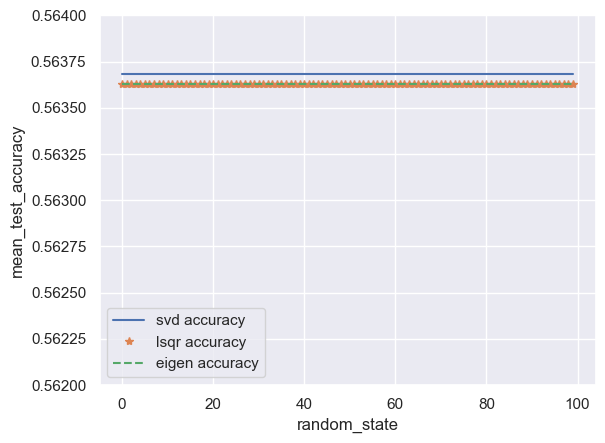

In [48]:
# plot both of the runs
plt.plot(random_state_vec, acc_svd_vec, label='svd accuracy')
plt.plot(random_state_vec, acc_lsqr_vec, '*', label='lsqr accuracy')
plt.plot(random_state_vec, acc_eigen_vec, '--', label='eigen accuracy')
plt.xlabel('random_state')
plt.ylabel('mean_test_accuracy')
plt.ylim([0.562, 0.564])
plt.legend()

In [34]:
MSE_1 = np.mean((np.square(np.array(acc_svd_vec) - np.array(acc_lsqr_vec))))
MSE_1

2.814344715020767e-09

In [35]:
MSE_2 = np.mean((np.square(np.array(acc_lsqr_vec) - np.array(acc_eigen_vec))))
MSE_2

0.0

In [36]:
MSE_3 = np.mean((np.square(np.array(acc_svd_vec) - np.array(acc_eigen_vec))))
MSE_3

2.814344715020767e-09

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see from the graph and from the MSE calculation, all the solvers bring the same performance. <br>
Therefore, in the Exhaustive Search we will use the default 'svd' solver when not testing shrinkage.

<b>2. shrinkage</b><br>
<br>
The possible values are:
* None: no shrinkage (default).

* ‘auto’: automatic shrinkage using the Ledoit-Wolf lemma.

* float between 0 and 1: fixed shrinkage parameter.

This should be left to None if covariance_estimator is used. <br>
Shrinkage works only with ‘lsqr’ and ‘eigen’ solvers.

In [49]:
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None,'auto'] + np.arange(0,0.1,0.01).tolist()
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'time'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,param_solver,param_shrinkage,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
2,lsqr,auto,0.346288,0.097029,0.564002,0.003771,1
3,eigen,auto,0.576779,0.066215,0.564002,0.003771,1
0,lsqr,None,0.111843,0.027205,0.563631,0.002010,3
1,eigen,None,0.201928,0.032484,0.563631,0.002010,3
4,lsqr,0.0,0.149956,0.021947,0.563631,0.002010,3
5,eigen,0.0,0.144604,0.013551,0.563631,0.002010,3


Best Estimator is: LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

Elapsed Fit Time: 3.242014169692993 [s]


<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, using the shrinkage with solvers of 'lsqr' and 'eigen' slightly improves the performance. <br>
Therefore, in the Exhaustive Search we will look into this parameter.

<b>3. priors</b><br>

Prior probabilities of a class is the probability that a randomly chosen example belongs to that class, which is also known as $\pi_c$. <br>
By default, the class proportions are inferred from the training data. <br>
In our case, because the data is imbalanced while also is multiclass, we take the default class priors that are infered from the training data. <br>
Because we use StratifiedKFold which preserves the data division, we can still infer the priors from the training data.

<b>4. n_components</b><br>
Number of components (lower or equal to min(n_classes - 1, n_features)) for dimensionality reduction. <br>
If None, will be set to min(n_classes - 1, n_features), for our case min(2-1,128) = 1. <br>

For LDA with two classes, such as our dataset, n_components must be at least 1. <br>
Therefore, it has no affect in our case.

<b> FER: We have 7 classes, so min(7-1,68)=6

In [50]:
param_grid = {
    'n_components': [1, 2, 3, 4, 5, 6],
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'time'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,param_n_components,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,1,1.998317,0.470426,0.563684,0.002069,1
1,2,2.162213,0.209485,0.563684,0.002069,1
2,3,2.255446,0.130595,0.563684,0.002069,1
3,4,2.264783,0.213254,0.563684,0.002069,1
4,5,1.061828,0.276338,0.563684,0.002069,1
5,6,0.780745,0.063576,0.563684,0.002069,1


Best Estimator is: LinearDiscriminantAnalysis(n_components=1)

Elapsed Fit Time: 5.0012171268463135 [s]


<u>Validation</u>:<br>
We will iterate through 30 different random_states, in order to validate the results we got above.

In [51]:
param_grid = {
    'n_components': [1, 2, 3, 4, 5, 6],
}

random_state_vec = np.arange(30)
results_df_i = pd.DataFrame()
for i in random_state_vec:
    [results_df,_,_] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=i, n_jobs=n_jobs, is_printing=[])
    results_df_i = results_df_i.append(results_df.sort_values(by='rank_test_accuracy').iloc[[0]])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates

In [52]:
results_df_i[['param_n_components', 'mean_test_accuracy']]

,param_n_components,mean_test_accuracy
0,1,0.563684
0,1,0.563684
0,1,0.563684
0,1,0.563684
0,1,0.563684
0,1,0.563684
0,1,0.563684
0,1,0.563684
0,1,0.563684
0,1,0.563684


In [53]:
results_df_i['param_n_components'].value_counts()

1    30
Name: param_n_components, dtype: int64

<b>5. store_covariance</b><br>
If True, the class covariance matrices are explicitly computed and stored in the self.covariance_ attribute. <br>
Therefore, the store_covariance parameter doesn't affect the accuracy of the classifier.

<b>6. tol</b><br>

Absolute threshold for a singular value to be considered significant. <br>
This parameter does not affect the predictions. It only controls a warning that is raised when features are considered to be colinear. <br>
Therefore, the tol parameter doesn't affect the accuracy of the classifier.

<b>7. covariance_estimator</b><br>

The covariance_estimator parameter specifies the method used to estimate the covariance matrix within each class. <br>
We researched about possible covariance estimators, and choose a few.

In [56]:
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import EllipticEnvelope
from sklearn.covariance import GraphicalLasso
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import MinCovDet
from sklearn.covariance import OAS

param_grid = {
    'solver': ['lsqr', 'eigen'],
    'covariance_estimator': [EmpiricalCovariance(), EllipticEnvelope(), 
                             LedoitWolf(), MinCovDet(), OAS(), None]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'time'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_solver,param_covariance_estimator,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
8,lsqr,OAS(),0.156413,0.015243,0.564373,0.003800,1
9,eigen,OAS(),0.257164,0.048518,0.564373,0.003800,1
4,lsqr,LedoitWolf(),0.231125,0.029777,0.564002,0.003808,3
5,eigen,LedoitWolf(),0.339492,0.027680,0.564002,0.003808,3
0,lsqr,EmpiricalCovariance(),0.174698,0.011314,0.563631,0.002010,5
1,eigen,EmpiricalCovariance(),0.236529,0.024746,0.563631,0.002010,5
10,lsqr,None,0.175125,0.015819,0.563631,0.002010,5
11,eigen,None,0.233192,0.024661,0.563631,0.002010,5


Best Estimator is: LinearDiscriminantAnalysis(covariance_estimator=OAS(), solver='lsqr')

Elapsed Fit Time: 152.80248427391052 [s]


<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the covariance_estimator does not significantly improves the performance. <br>

<h3>Exhaustive Search:</h3>

In [61]:
param_grid = {
    'solver': ['lsqr', 'eigen'], 
    'covariance_estimator': [EmpiricalCovariance(), EllipticEnvelope(), 
                             LedoitWolf(), MinCovDet(), OAS(), None]    
}

[results_df, best_estimator_LDA1, clf_fitted] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['report', 'best', 'time'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_solver,param_covariance_estimator,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
8,lsqr,OAS(),0.186777,0.020953,0.564373,0.003800,1
9,eigen,OAS(),0.239162,0.033090,0.564373,0.003800,1
4,lsqr,LedoitWolf(),0.214444,0.019542,0.564002,0.003808,3
5,eigen,LedoitWolf(),0.318695,0.015348,0.564002,0.003808,3
0,lsqr,EmpiricalCovariance(),0.178388,0.007482,0.563631,0.002010,5
1,eigen,EmpiricalCovariance(),0.224603,0.016060,0.563631,0.002010,5
10,lsqr,None,0.164890,0.030284,0.563631,0.002010,5
11,eigen,None,0.217362,0.006612,0.563631,0.002010,5


Best Estimator is: LinearDiscriminantAnalysis(covariance_estimator=OAS(), solver='lsqr')

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,291,8,22,66,109,81,37
disgust,31,15,4,8,8,11,3
fear,82,6,95,75,149,115,96
happy,33,1,21,1113,86,27,32
neutral,67,1,37,64,556,126,23
sad,83,2,48,62,211,212,19
surprise,26,0,25,64,58,9,373




The Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.47      0.47       614
     disgust       0.45      0.19      0.27        80
        fear       0.38      0.15      0.22       618
       happy       0.77      0.85      0.81      1313
     neutral       0.47      0.64      0.54       874
         sad       0.36      0.33      0.35       637
    surprise       0.64      0.67      0.66       555

    accuracy                           0.57      4691
   macro avg       0.51      0.47      0.47      4691
weighted avg       0.55      0.57      0.55      4691



Elapsed Fit Time: 158.80237293243408 [s]


In [58]:
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [0.03, 0.05, 0.06]   
}

[results_df_LDA, best_estimator_LDA2, clf_fitted_LDA] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['report', 'best', 'time'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,param_solver,param_shrinkage,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,lsqr,0.03,0.191735,0.024874,0.553233,0.003138,1
1,eigen,0.03,0.244820,0.025258,0.553233,0.003138,1
2,lsqr,0.05,0.197650,0.019205,0.549520,0.002721,3
3,eigen,0.05,0.216878,0.006724,0.549520,0.002721,3
4,lsqr,0.06,0.124503,0.013831,0.548724,0.004239,5
5,eigen,0.06,0.146042,0.001395,0.548724,0.004239,5


Best Estimator is: LinearDiscriminantAnalysis(shrinkage=0.03, solver='lsqr')

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,273,3,19,81,126,71,41
disgust,32,9,5,9,11,12,2
fear,86,3,59,77,173,111,109
happy,27,1,14,1114,97,26,34
neutral,68,1,28,59,587,113,18
sad,91,2,46,69,239,174,16
surprise,31,0,26,63,65,6,364




The Classification Report:
              precision    recall  f1-score   support

       angry       0.45      0.44      0.45       614
     disgust       0.47      0.11      0.18        80
        fear       0.30      0.10      0.14       618
       happy       0.76      0.85      0.80      1313
     neutral       0.45      0.67      0.54       874
         sad       0.34      0.27      0.30       637
    surprise       0.62      0.66      0.64       555

    accuracy                           0.55      4691
   macro avg       0.48      0.44      0.44      4691
weighted avg       0.52      0.55      0.52      4691



Elapsed Fit Time: 0.6088755130767822 [s]


In [59]:
param_grid = {
    'solver': ['svd']
}

[results_df, best_estimator_LDA3, clf_fitted] = eval_classifier(base_estimator_LDA, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['report', 'best', 'time'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,param_solver,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,svd,0.303433,0.041017,0.563684,0.002069,1


Best Estimator is: LinearDiscriminantAnalysis()

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,292,13,31,58,111,76,33
disgust,28,20,5,9,9,9,0
fear,78,9,115,71,129,123,93
happy,26,1,28,1122,74,26,36
neutral,64,3,42,57,557,129,22
sad,84,3,45,61,190,233,21
surprise,22,1,32,62,52,17,369




The Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.48      0.48       614
     disgust       0.40      0.25      0.31        80
        fear       0.39      0.19      0.25       618
       happy       0.78      0.85      0.82      1313
     neutral       0.50      0.64      0.56       874
         sad       0.38      0.37      0.37       637
    surprise       0.64      0.66      0.65       555

    accuracy                           0.58      4691
   macro avg       0.51      0.49      0.49      4691
weighted avg       0.56      0.58      0.56      4691



Elapsed Fit Time: 0.7801916599273682 [s]


In [ ]:
# end timer for full classifier evaluation run
elapsed_classifier = time() - t_classifier
print("Elapsed Full Classifier Evaluation Time: " + str(elapsed_classifier) + " [s]")

<a id="LDA_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>LDA Overall Conclusion:</u></h2><br>
In this section, we tested the performance of LDA algorithm on our dataset. <br>
We went over possible parameters of the classifier, and checked their influence on the performance. <br>

Our choose for the best LDA classifier is the default classifier: LinearDiscriminantAnalysis().<br>

We saw that when we use covariance estimator param_covariance_estimator: OAS() we got 1% higher in accuracy but 5 times in fitting time, and the time factor is also important for us, therefore we decided to stay with the default clasisifier. <br>

<a id="GNB"></a>
<h1>GNB</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

Gaussian Naive Bayes is a probabilistic classifier based on Bayes' theorem with the assumption of independence between features. <br> It models each class's distribution as a gaussian distribution and calculates the probability of examples belonging to each class given its feature values.

GNB assumes the features are independent.

In [62]:
# start timer for full classifier evaluation run
t_classifier = time()

<h3>Params Search:</h3>

In [63]:
from sklearn.naive_bayes import GaussianNB

base_estimator_GNB = GaussianNB()
base_estimator_GNB.get_params()

{'priors': None, 'var_smoothing': 1e-09}

<h4>The params are:</h4>
1. priors <br>
2. var_smoothing <br>

<b>1. priors</b><br>

Prior probabilities of a class is the probability that a randomly chosen example belongs to that class, which is also known as $\pi_c$. <br>
By default, the class proportions are inferred from the training data. <br>
In our case, because the data is imbalanced while also is multiclass, we take the default class priors that are infered from the training data. <br>
Because we use StratifiedKFold which preserves the data division, we can still infer the priors from the training data.

<b>2. var_smoothing</b><br>

The var_smoothing parameter introduces a small amount of smoothing to the estimated covariance matrices. It adds a constant value (the minimum variance) to the diagonal elements (variances) of the covariance matrix. <br>
This ensures the diagonal elements never become zero, preventing singularities (division by zero) in the calculations.

In [64]:
param_grid = {
    'var_smoothing': [(10**var_s) for var_s in np.arange(0,-11,-1,dtype=float)]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_GNB, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'time'])

Fitting 5 folds for each of 11 candidates, totalling 55 fits


,param_var_smoothing,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
2,0.01,0.191445,0.007419,0.311760,0.009882,1
3,0.001,0.215296,0.026856,0.311283,0.010034,2
4,0.0001,0.209135,0.008001,0.311283,0.010039,3
5,0.00001,0.208272,0.028134,0.311283,0.010039,3
6,0.000001,0.241682,0.056585,0.311283,0.010039,3
7,0.0,0.178841,0.057607,0.311283,0.010039,3
8,0.0,0.167916,0.068155,0.311283,0.010039,3
9,0.0,0.201377,0.081966,0.311283,0.010039,3
10,0.0,0.181671,0.011469,0.311283,0.010039,3


Best Estimator is: GaussianNB(var_smoothing=0.01)

Elapsed Fit Time: 2.018195390701294 [s]


<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the var_smoothing does impact the performance. <br>

In [ ]:
# end timer for full classifier evaluation run
elapsed_classifier = time() - t_classifier
print("Elapsed Full Classifier Evaluation Time: " + str(elapsed_classifier) + " [s]")

<a id="GNB_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>GNB Overall Conclusion:</u></h2><br>
In this section, we tested the performance of GNB algorithm on our dataset. <br>
We went over possible parameters of the classifier, and we didn't find a hyper-parameter that fits our needs. <br>

Our choose for the best GNB classifier is the default classifier: GaussianNB()<br>

<a id="Decision_Tree"></a>
<h1>Decision Tree</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

Decision Tree is a classification algorithm. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

In [25]:
# start timer for full classifier evaluation run
t_classifier = time()

<h3>Params Search:</h3>

In [26]:
from sklearn.tree import DecisionTreeClassifier

base_estimator_DT = DecisionTreeClassifier()
base_estimator_DT.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

<h4>The params are:</h4>
1. random_state <br>
2. splitter <br>
3. max_depth <br>
4. min_samples_split <br>
5. min_samples_leaf <br>
6. min_weight_fraction_leaf <br>
7. max_features <br>
8. criterion <br>
9. max_leaf_nodes <br>
10. min_impurity_decrease <br>
11. class_weight <br>
12. ccp_alpha <br>

<b>1. random_state</b><br>

Controls the randomness of the estimator. <br>
We are setting a specific seed of 0, to help us compare different parameters, and then verify the results using different random_states. <br>

<b>2. splitter</b><br>

The strategy used to choose the split at each node.

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,param_splitter,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,best,0,balanced,2.776626,0.036943,0.400509,0.003832,1
1,random,0,balanced,0.480704,0.009799,0.396796,0.004090,2


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', random_state=0)



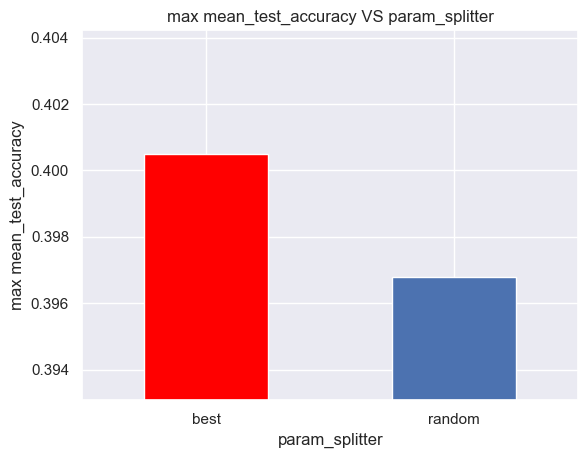

Elapsed Fit Time: 7.562546730041504 [s]


In [28]:
param_grid = {
    'splitter': ['best', 'random'],
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the splitter does not significantly improve the performance. <br>
For this run, the random strategy was slightly better. <br>
We will validate this result with different random_states.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [29]:
param_grid = {
    'splitter': ['best', 'random'],
    'random_state': np.arange(30), 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [30]:
# extract from the results the runs mean_test_accuracy for each strategy vs the random_state
best_vec_df = results_df[results_df['param_splitter']=='best'][['param_random_state', 'mean_test_accuracy']]
random_vec_df = results_df[results_df['param_splitter']=='random'][['param_random_state', 'mean_test_accuracy']]

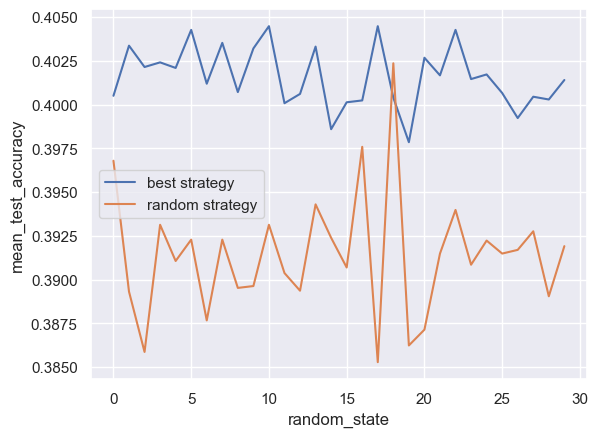

In [31]:
# plot both of the runs
plt.plot(best_vec_df[['param_random_state']].values, best_vec_df[['mean_test_accuracy']].values, label='best strategy')
plt.plot(random_vec_df[['param_random_state']].values, random_vec_df[['mean_test_accuracy']].values, label='random strategy')
plt.xlabel('random_state')
plt.ylabel('mean_test_accuracy')
plt.legend()

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
Even though the 'random' strategy gave better results for the random_state=0, we can see that overall the 'best' strategy triumphs for almost all the other random_states. <br>

<b>3. max_depth</b><br>

The max_depth is the maximum depth of the tree. <br>
A shallow tree may underfit the data, capturing too few patterns, while a deep tree may overfit the data.

Fitting 5 folds for each of 199 candidates, totalling 995 fits


,param_max_depth,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
28,29,0,balanced,3.580728,0.048587,0.402949,0.005976,1
26,27,0,balanced,3.570505,0.067221,0.402418,0.005663,2
29,30,0,balanced,3.600319,0.051726,0.401941,0.005903,3
23,24,0,balanced,3.549099,0.104010,0.401941,0.004537,4
25,26,0,balanced,3.588876,0.068269,0.401888,0.004867,5


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', max_depth=29, random_state=0)



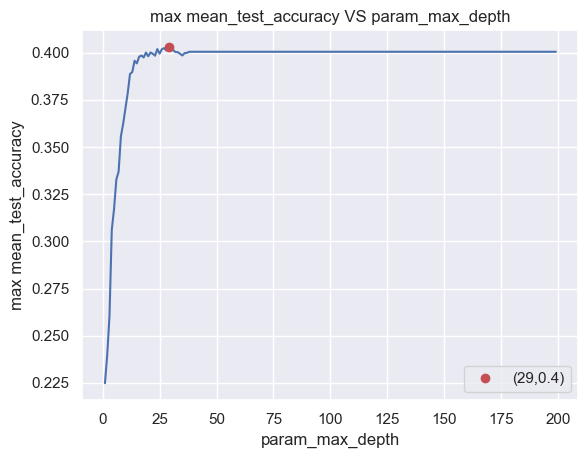

Elapsed Fit Time: 180.14137411117554 [s]


In [32]:
param_grid = {
    'max_depth': np.arange(1,200),
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best max_depth is 7. <br>
We can see that for lower values of max_depth, we stop the tree early from growing, therefore we get not as good performance. <br>
Moreover, we can see that for higher max_depth values, the accuracy goes down due to the effect of overfitting. <br>
We will validate this result with different random_states.

<u>Validation</u>:<br>
We will iterate through 10 different random_states of the tree, in order to validate the results we got above.

In [33]:
random_state_vec = np.arange(10)
max_depth_vec = []

for random_state in random_state_vec:
    param_grid = {
        'max_depth': np.arange(1,50),
        'random_state': [random_state], 
        'class_weight': ['balanced']
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    max_depth_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_max_depth'].values[0])

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits


Text(0, 0.5, 'best max_depth')

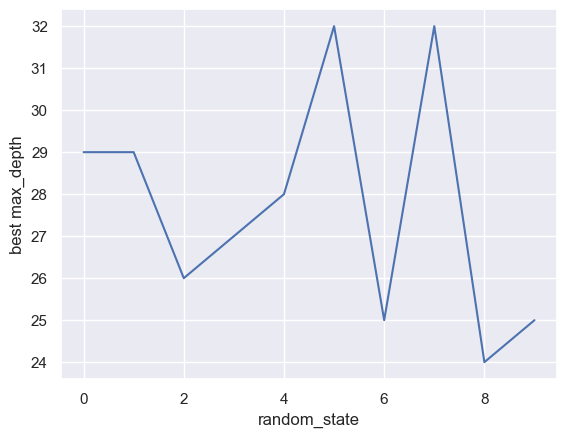

In [34]:
plt.plot(random_state_vec, max_depth_vec)
plt.xlabel('random_state')
plt.ylabel('best max_depth')

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see after the validation, the best max_depth is indeed 7 for majority of the random_states. <br>
In the Exhaustive Search we will also include 6.

<b>4. min_samples_split</b><br>

The minimum number of samples required to split an internal node. <br>
Small value may overfit the data.

Fitting 5 folds for each of 98 candidates, totalling 490 fits


,param_min_samples_split,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,2,0,balanced,3.769239,0.066100,0.400509,0.003832,1
1,3,0,balanced,3.681632,0.068730,0.398917,0.005001,2
2,4,0,balanced,3.673606,0.080288,0.393348,0.002496,3
3,5,0,balanced,3.626129,0.080368,0.393188,0.003054,4
5,7,0,balanced,3.528222,0.085228,0.391278,0.007191,5


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', random_state=0)



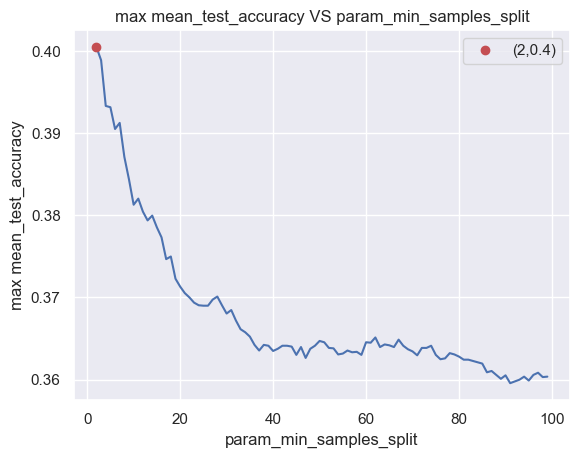

Elapsed Fit Time: 74.39910674095154 [s]


In [36]:
param_grid = {
    'min_samples_split': np.arange(2,100,1),
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best min_samples_split is 66. <br>
We will validate this result with different random_states.

<u>Validation</u>:<br>
We will iterate through 10 different random_states of the tree, in order to validate the results we got above.

In [37]:
random_state_vec = np.arange(10)
min_samples_split_vec = []

for random_state in random_state_vec:
    param_grid = {
        'min_samples_split': np.arange(2,100,1),
        'random_state': [random_state], 
        'class_weight': ['balanced']
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    min_samples_split_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_min_samples_split'].values[0])

Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Fitting 5 folds for each of 98 candidates, totalling 490 fits


Text(0, 0.5, 'best min_samples_split')

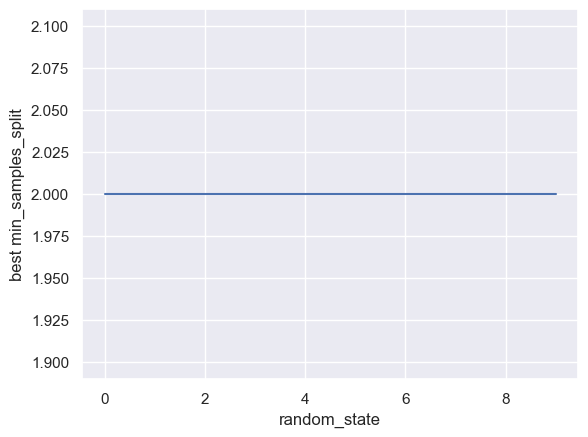

In [38]:
plt.plot(random_state_vec, min_samples_split_vec)
plt.xlabel('random_state')
plt.ylabel('best min_samples_split')

In [39]:
# best values of min_samples_split
np.unique(min_samples_split_vec)

array([2])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best values of min_samples_split varies. <br>
In the Exhaustive Search, we will check all of the best values.

<b>5. min_samples_leaf</b><br>

The minimum number of samples required to be at a leaf node. <br>
By setting a minimum number of samples required at a leaf node, we can prevent the tree from creating overfitting by creating branches with very few samples.

Fitting 5 folds for each of 239 candidates, totalling 1195 fits


,param_min_samples_leaf,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,1,0,balanced,3.588316,0.054783,0.400509,0.003832,1
1,2,0,balanced,3.380556,0.051982,0.386611,0.003870,2
3,4,0,balanced,3.162336,0.092531,0.384595,0.003413,3
2,3,0,balanced,3.256637,0.051305,0.384489,0.002925,4
4,5,0,balanced,3.038946,0.070472,0.380828,0.005511,5


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', random_state=0)



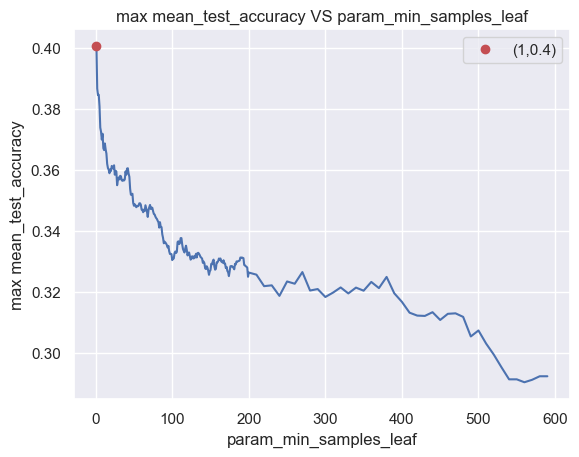

Elapsed Fit Time: 91.24782919883728 [s]


In [42]:
param_grid = {
    'min_samples_leaf': np.arange(1,200).tolist() + np.arange(200,600,10).tolist(),
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the min_samples_leaf is 89. <br>
The right amount of min_samples_leaf will prevent underfitting and overfitting. <br>

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [43]:
random_state_vec = np.arange(10)
min_samples_leaf_vec = []

for random_state in random_state_vec:
    param_grid = {
        'min_samples_leaf': np.arange(1,100),
        'random_state': [random_state], 
        'class_weight': ['balanced']
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    min_samples_leaf_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_min_samples_leaf'].values[0])

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits


Text(0, 0.5, 'best min_samples_leaf')

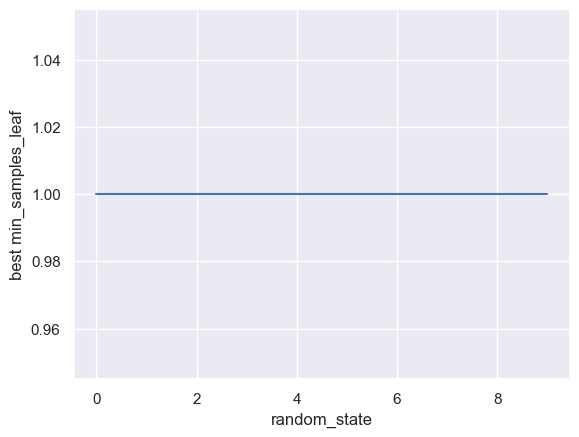

In [44]:
plt.plot(random_state_vec, min_samples_leaf_vec)
plt.xlabel('random_state')
plt.ylabel('best min_samples_leaf')

In [45]:
# best values of min_samples_leaf
np.unique(min_samples_leaf_vec)

array([1])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, after validation, the best min_samples_leaf is 89. <br>
In the Exhaustive Search we will search around that value.

<b>6. min_weight_fraction_leaf</b><br>

The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. <br>
Samples have equal weight when sample_weight is not provided. <br>
We will not use this parameter in our evaluation.

<b>7. max_features</b><br>

The parameter max_features is the number of features to consider when looking for the best split.

Fitting 5 folds for each of 136 candidates, totalling 680 fits


,param_max_features,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
124,125,0,balanced,3.192189,0.030001,0.405177,0.004652,1
116,117,0,balanced,3.023960,0.031051,0.403321,0.003085,2
52,53,0,balanced,1.405459,0.015724,0.402579,0.009918,3
130,131,0,balanced,3.373269,0.032000,0.402472,0.004811,4
125,126,0,balanced,3.208664,0.046083,0.402207,0.004853,5


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', max_features=125,
                       random_state=0)



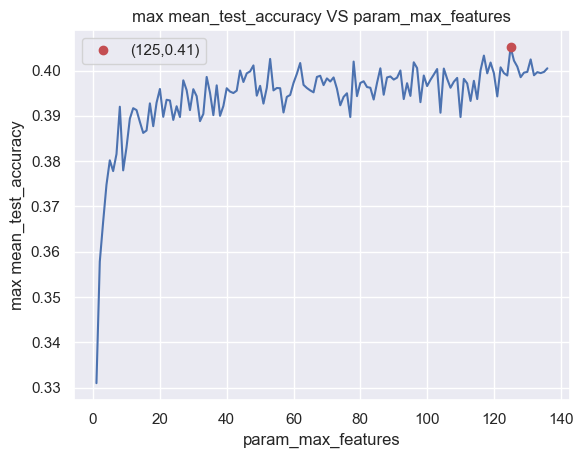

Elapsed Fit Time: 65.21236228942871 [s]


In [46]:
param_grid = {
    'max_features': np.arange(1,137),
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the max_features is 114. <br>

<u>Validation</u>:<br>
We will iterate through 10 different random_states of the tree, in order to validate the results we got above.

In [47]:
random_state_vec = np.arange(10)
max_features_vec = []

for random_state in random_state_vec:
    param_grid = {
        'max_features': np.arange(1,137),
        'random_state': [random_state], 
        'class_weight': ['balanced']
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    max_features_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_max_features'].values[0])

Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits
Fitting 5 folds for each of 136 candidates, totalling 680 fits


Text(0, 0.5, 'best min_samples_leaf')

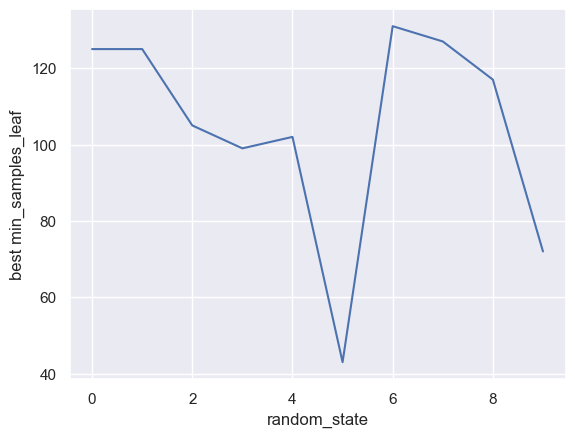

In [48]:
plt.plot(random_state_vec, max_features_vec)
plt.xlabel('random_state')
plt.ylabel('best min_samples_leaf')

In [49]:
# best values of the feature
np.unique(max_features_vec)

array([ 43,  72,  99, 102, 105, 117, 125, 127, 131])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the validation is noisey. <br>
As we suspected from the previous run, therefore we will take the max_features of 136, half of it 68, and the root square of it ~12.

<b>8. criterion</b><br>

The criterion parameter defines the function to measure the quality of a split.

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,param_criterion,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,gini,0,balanced,3.065009,0.021512,0.400509,0.003832,1
1,entropy,0,balanced,4.639966,0.062321,0.397539,0.009678,2


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', random_state=0)



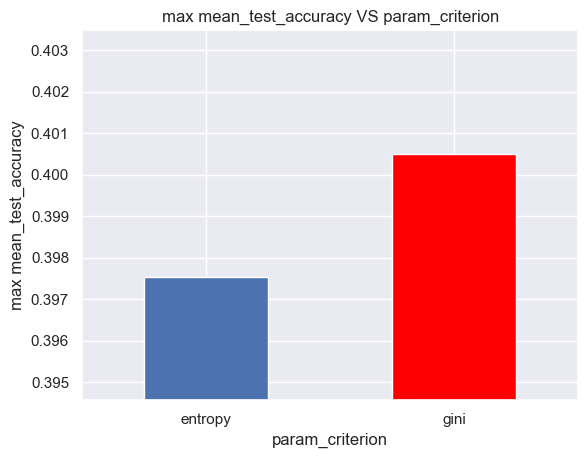

Elapsed Fit Time: 8.195555925369263 [s]


In [50]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the criterion does not significantly improves the performance. <br>

<b>9. max_leaf_nodes</b><br>

The max_leaf_nodes parameter sets a limit on the maximum number of leaf nodes the tree can have. Leaf nodes are the terminal nodes where final classifications or predictions are made. <br>

Fitting 5 folds for each of 238 candidates, totalling 1190 fits


,param_max_leaf_nodes,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
221,430,0,balanced,2.404713,0.089422,0.394939,0.004824,1
220,420,0,balanced,2.389154,0.080394,0.394939,0.005012,2
219,410,0,balanced,2.373935,0.064149,0.394939,0.005276,3
228,500,0,balanced,2.502144,0.058806,0.394621,0.004817,4
218,400,0,balanced,2.379827,0.049360,0.394515,0.005729,5


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=430,
                       random_state=0)



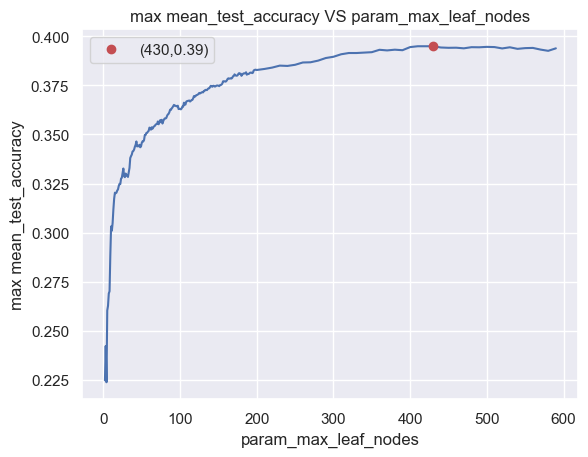

Elapsed Fit Time: 106.68205618858337 [s]


In [53]:
param_grid = {
    'max_leaf_nodes': np.arange(2,200).tolist() + np.arange(200,600,10).tolist(),
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best max_leaf_nodes is 370.<br>
We can also see an area in 150-250 that has another peak. <br>
A tree with a lower max_leaf_nodes value will be shallower, as it stops growing once it hits the leaf node limit. We can see in the graph that for lower values of max_leaf_nodes, the performance is worse.<br>
A tree with a higher max_leaf_nodes value can lead to overfitting, and we can see in the graph that as the max_leaf_nodes grows, the performance worsens.

<b>10. min_impurity_decrease</b><br>

This parameter sets a minimum threshold for the acceptable decrease in impurity when making a split. <br>
It prevents the tree from making unnecessary splits that don't significantly improve the purity of the child nodes. <br>

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,param_min_impurity_decrease,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.0,0,balanced,3.048332,0.061880,0.400509,0.003832,1
1,0.01,0,balanced,0.424759,0.019352,0.224816,0.002272,2
2,0.02,0,balanced,0.247553,0.034937,0.192664,0.073336,3
3,0.03,0,balanced,0.243852,0.020300,0.192664,0.073336,3
4,0.04,0,balanced,0.211018,0.036323,0.192664,0.073336,3
5,0.05,0,balanced,0.225034,0.033983,0.192664,0.073336,3
6,0.06,0,balanced,0.215970,0.008151,0.192664,0.073336,3
7,0.07,0,balanced,0.221807,0.013772,0.192664,0.073336,3
8,0.08,0,balanced,0.196717,0.008705,0.192664,0.073336,3
9,0.09,0,balanced,0.173455,0.004678,0.192664,0.073336,3


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', random_state=0)



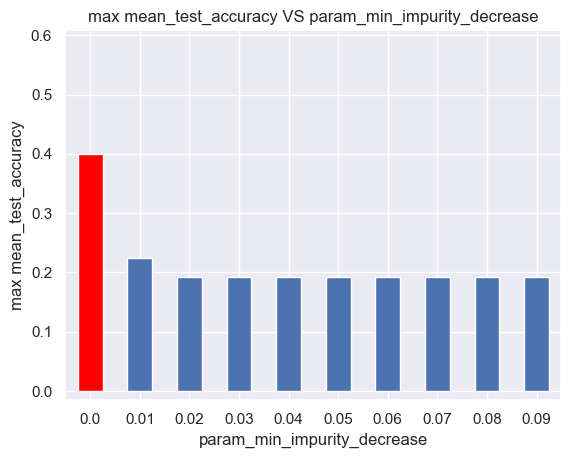

Elapsed Fit Time: 6.678605318069458 [s]


In [54]:
param_grid = {
    'min_impurity_decrease': np.round(np.arange(0,0.1, 0.01),3),
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best min_impurity_decrease is the default 0.<br>
Therefore, we will not change its default value.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [55]:
random_state_vec = np.arange(30)
min_impurity_decrease_vec = []

for random_state in random_state_vec:
    param_grid = {
        'min_impurity_decrease': np.round(np.arange(0,0.1, 0.01),3),
        'random_state': [random_state], 
        'class_weight': ['balanced']
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    min_impurity_decrease_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_min_impurity_decrease'].values[0])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each

Text(0, 0.5, 'best min_impurity_decrease')

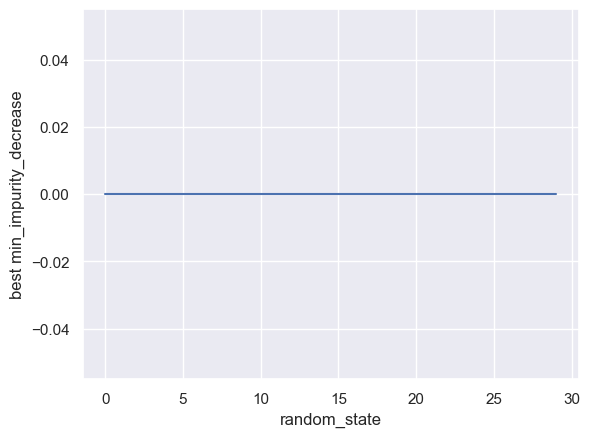

In [56]:
plt.plot(random_state_vec, min_impurity_decrease_vec)
plt.xlabel('random_state')
plt.ylabel('best min_impurity_decrease')

In [57]:
# best values of the feature
np.unique(min_impurity_decrease_vec)

array([0.])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best min_impurity_decrease is the default 0, even for different random_states.<br>
Therefore, we will not change its default value.

<b>11. class_weight</b><br>
Weights associated with classes. <br>
We will not evaluate this parameter in our search.

<b>12. ccp_alpha</b><br>
The parameter CCP aims to find a simpler subtree within the fully grown tree that offers a good balance between accuracy and complexity. <br>
It prevents overfitting by removing parts of the decision tree that are not providing significant improvements in accuracy.

Fitting 5 folds for each of 11 candidates, totalling 55 fits


,param_ccp_alpha,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.0,0,balanced,3.623462,0.061177,0.400509,0.003832,1
1,0.01,0,balanced,3.763600,0.098427,0.224816,0.002272,2
2,0.02,0,balanced,3.723175,0.064697,0.192664,0.073336,3
3,0.03,0,balanced,3.749683,0.093048,0.192664,0.073336,3
4,0.04,0,balanced,3.706701,0.033351,0.192664,0.073336,3
5,0.05,0,balanced,3.734188,0.080547,0.192664,0.073336,3
6,0.06,0,balanced,3.753554,0.058191,0.192664,0.073336,3
7,0.07,0,balanced,3.713950,0.066109,0.192664,0.073336,3
8,0.08,0,balanced,3.340594,0.047988,0.192664,0.073336,3
9,0.09,0,balanced,3.328942,0.030978,0.192664,0.073336,3


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', random_state=0)



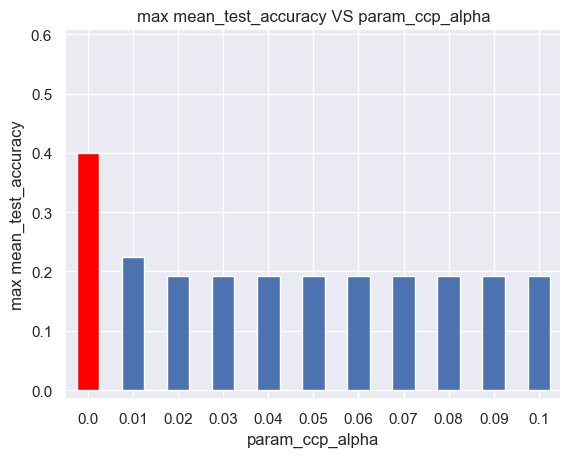

Elapsed Fit Time: 14.370617866516113 [s]


In [58]:
param_grid = {
    'ccp_alpha': np.round(np.arange(0,0.11, 0.01),3),
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best ccp_alpha is the default 0.<br>
Therefore, we will not change its default value.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [59]:
random_state_vec = np.arange(30)
ccp_alpha_vec = []

for random_state in random_state_vec:
    param_grid = {
        'ccp_alpha': np.round(np.arange(0,0.1, 0.01),3),
        'random_state': [random_state], 
        'class_weight': ['balanced']
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    ccp_alpha_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_ccp_alpha'].values[0])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each

Text(0, 0.5, 'best ccp_alpha')

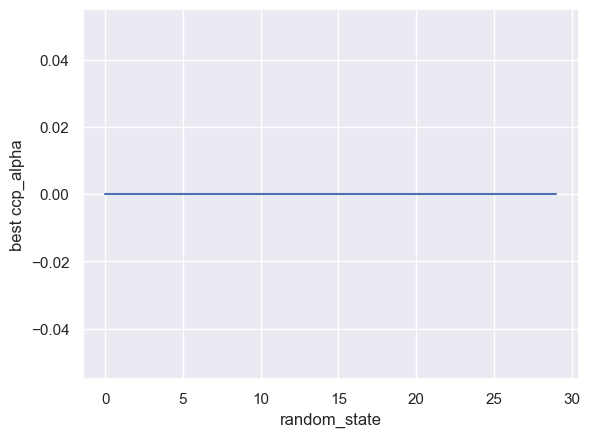

In [60]:
plt.plot(random_state_vec, ccp_alpha_vec)
plt.xlabel('random_state')
plt.ylabel('best ccp_alpha')

In [61]:
# best values of the feature
np.unique(ccp_alpha_vec)

array([0.])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best ccp_alpha is the default 0, even for different random_states.<br>
Therefore, we will not change its default value.

<h3>Exhaustive Search:</h3>

In [62]:
param_grid = {    
    'max_depth': [29, 26, 28, 32, 25, 24],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [43,  72,  99, 102, 105, 117, 125, 127, 131],
    'criterion': ['gini'],
    'max_leaf_nodes': [400, 410, 420, 430, 500], 
    'random_state': [0], 
    'class_weight': ['balanced']
}

[results_df_DT, best_estimator_DT, clf_fitted_DT] = eval_classifier(base_estimator_DT, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion,param_max_leaf_nodes,param_random_state,param_class_weight,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
36,29,2,1,127,gini,410,0,balanced,2.104839,0.017963,0.394462,0.005433,1
81,26,2,1,127,gini,410,0,balanced,2.212216,0.047132,0.394462,0.005433,1
126,28,2,1,127,gini,410,0,balanced,2.125376,0.022610,0.394462,0.005433,1
171,32,2,1,127,gini,410,0,balanced,2.162269,0.028704,0.394462,0.005433,1
216,25,2,1,127,gini,410,0,balanced,2.185195,0.021264,0.394462,0.005433,1
261,24,2,1,127,gini,410,0,balanced,2.152219,0.028846,0.394462,0.005433,1


Best Estimator is: DecisionTreeClassifier(class_weight='balanced', max_depth=29, max_features=127,
                       max_leaf_nodes=410, random_state=0)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,153,27,74,57,151,112,40
disgust,6,32,4,5,14,14,5
fear,68,22,108,59,153,138,70
happy,116,34,88,719,172,112,72
neutral,64,39,83,46,403,201,38
sad,55,20,87,62,230,161,22
surprise,38,7,83,32,77,45,273




The Classification Report:
              precision    recall  f1-score   support

       angry       0.31      0.25      0.27       614
     disgust       0.18      0.40      0.25        80
        fear       0.20      0.17      0.19       618
       happy       0.73      0.55      0.63      1313
     neutral       0.34      0.46      0.39       874
         sad       0.21      0.25      0.23       637
    surprise       0.53      0.49      0.51       555

    accuracy                           0.39      4691
   macro avg       0.36      0.37      0.35      4691
weighted avg       0.43      0.39      0.40      4691



Elapsed Fit Time: 122.74796175956726 [s]


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

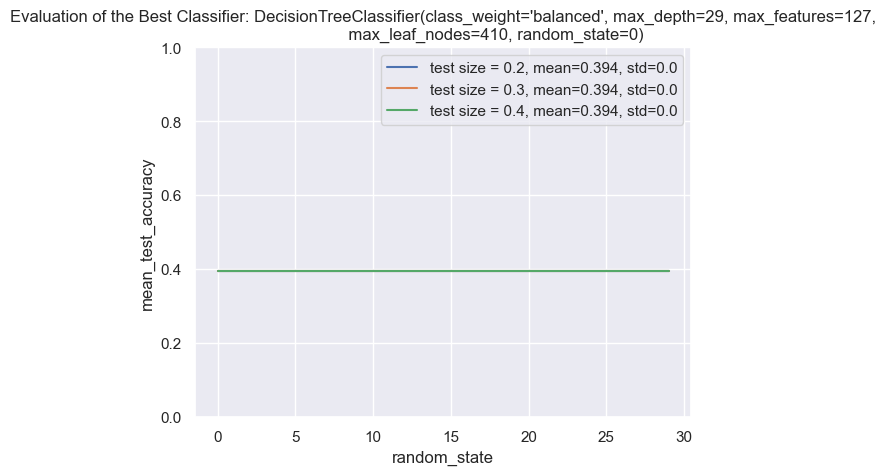

In [63]:
eval_best(best_estimator_DT, base_estimator_DT, X_train, X_test, y_train, y_test, Labels, n_jobs)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
In order to make sure that our decision decided optimal classifier does represent well the true optimal classifier, so we conducted model validation by testing the best classifier on different test and train dataset divisions (test_size), and on different dataset shuffles (random_state). <br>
As we can see, the model validation is stable.

In [ ]:
# end timer for full classifier evaluation run
elapsed_classifier = time() - t_classifier
print("Elapsed Full Classifier Evaluation Time: " + str(elapsed_classifier) + " [s]")

<a id="Decision_Tree_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>Decision Tree Overall Conclusion:</u></h2><br>
In this section, we tested the performance of Decision Tree algorithm on our dataset. <br>
We went over possible parameters of the classifier, and checked their influence on the performance. <br>

Our choice for the best Decision Tree classifier is: DecisionTreeClassifier(max_depth=7, max_features=42, max_leaf_nodes=55, min_samples_leaf=87, min_samples_split=63, random_state=0) which brings accuracy of 0.70 and an f1 score of 0.70.<br>

<a id="Random_Forest"></a>
<h1>Random Forest</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

A Random Forest is a classifier that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. <br>
The Random Forest combines the output of multiple decision trees to reach a single result

In [25]:
# start timer for full classifier evaluation run
t_classifier = time()

<h3>Params Search:</h3>

In [26]:
from sklearn.ensemble import RandomForestClassifier

base_estimator_RF = RandomForestClassifier()
base_estimator_RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<h4>The params are:</h4>
1. random_state <br>
2. n_estimators <br>
3. criterion <br>
4. max_depth <br>
5. min_samples_split <br>
6. min_samples_leaf <br>
7. min_weight_fraction_leaf <br>
8. max_features <br>
9. max_leaf_nodes <br>
10. min_impurity_decrease <br>
11. bootstrap <br>
12. oob_score <br>
13. n_jobs <br>
14. verbose <br>
15. warm_start <br>
16. class_weight <br>
17. ccp_alpha <br>
18. max_samples

<b>1. random_state</b><br>

Controls the randomness of the estimator. <br>
We are setting a specific seed of 0, to help us compare different parameters.

<b>2. n_estimators</b><br>
The parameter n_estimators is the number of trees in the forest. <br>
Each tree learns a slightly different mapping from features to predictions, and averaging the predictions of many trees reduces variance and improves generalization. <br>
Therefore, as a result we could get a higher accuracy when n_estimators is the right amount of trees. <br>
However, if n_estimators is too high, which means if we use too many trees, the model could overfit as it will become too sensitive to the training dataset. <br>
As well as if n_estimators is too low, which means if we use not enough trees, the model could underfit as it will not fulfil its full potential.

Fitting 5 folds for each of 112 candidates, totalling 560 fits


,param_n_estimators,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
110,500,0,82.862884,0.195825,0.541669,0.005166,1
111,1000,0,149.958212,0.283705,0.541085,0.005246,2
109,400,0,69.867391,0.223141,0.540131,0.005151,3
107,260,0,47.477020,0.125282,0.539813,0.006691,4
106,240,0,43.938565,0.129850,0.538646,0.007500,5


Best Estimator is: RandomForestClassifier(n_estimators=500, random_state=0)



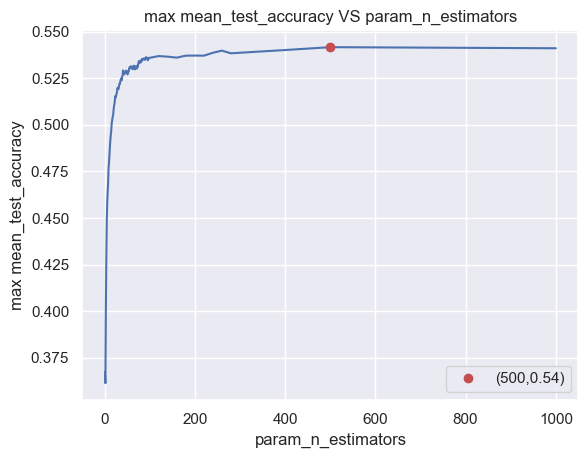

Elapsed Fit Time: 558.8322715759277 [s]


In [45]:
param_grid = {
    'n_estimators': np.arange(1,100, 1).tolist() + np.arange(100,300, 20).tolist() + [400, 500, 1000],
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, increasing the n_estimators increases the accuracy until a certain point, after that the accuracy converges. <br>
In addition, in the range of the lower values of n_estimators the accuracy is low.

<u>Validation</u>:<br>
We will iterate through 30 different random_states in the forest, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)
n_estimators_vec = []

for random_state in random_state_vec:
    param_grid = {
        'n_estimators': [272, 270, 200, 446, 445],
        'random_state': [random_state]
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    n_estimators_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_n_estimators'].values[0])

In [ ]:
plt.stem(random_state_vec, n_estimators_vec)
plt.xlabel('random_state')
plt.ylabel('best max_leaf_nodes')

In [ ]:
# best values of the feature and their frequency
unique, counts = np.unique(n_estimators_vec, return_counts=True)
print(np.asarray((unique, counts)).T)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see the n_estimators varies.<br>
Therefore, in the Exhaustive Search we will include [272, 445].

<b>3. criterion</b><br>

The criterion parameter defines the function to measure the quality of a split.

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,param_criterion,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
1,entropy,0,25.605111,0.163585,0.538964,0.005394,1
0,gini,0,15.875366,0.068092,0.535940,0.007148,2


Best Estimator is: RandomForestClassifier(criterion='entropy', random_state=0)



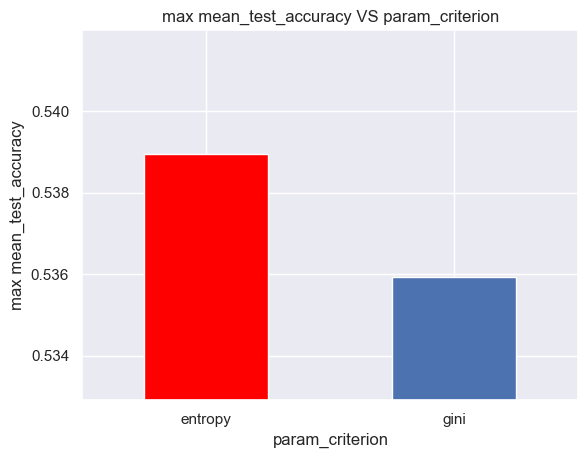

Elapsed Fit Time: 55.082176208496094 [s]


In [44]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the criterion does not significantly improves the performance. <br>

<u>Validation</u>:<br>
We will iterate through 100 different random_states of the forest, in order to validate the results we got above.

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'random_state': np.arange(100)
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])

In [ ]:
# extract from the results the runs mean_test_accuracy for each strategy vs the random_state
gini_vec_df = results_df[results_df['param_criterion']=='gini'][['param_random_state', 'mean_test_accuracy']]
entropy_vec_df = results_df[results_df['param_criterion']=='entropy'][['param_random_state', 'mean_test_accuracy']]

In [ ]:
# plot both of the runs
plt.plot(gini_vec_df[['param_random_state']].values, gini_vec_df[['mean_test_accuracy']].values, label='gini criterion')
plt.plot(entropy_vec_df[['param_random_state']].values, entropy_vec_df[['mean_test_accuracy']].values, label='entropy criterion')
plt.xlabel('criterion')
plt.ylabel('mean_test_accuracy')
plt.legend()

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the criterion varies. <br>
In the Exhaustive Search, we will include both 'gini' and 'entropy'.

<b>4. max_depth</b><br>

The max_depth is the maximum depth of the trees. <br>
Shallow trees may underfit the data, capturing too few patterns, while deep trees may overfit the data.

Fitting 5 folds for each of 49 candidates, totalling 245 fits


,param_max_depth,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
22,23,0,18.399064,0.048626,0.539760,0.006147,1
25,26,0,18.316693,0.055754,0.537319,0.003168,2
34,35,0,18.990615,0.068925,0.536683,0.006260,3
26,27,0,18.511838,0.107124,0.536630,0.002260,4
27,28,0,18.536749,0.044385,0.536152,0.005424,5


Best Estimator is: RandomForestClassifier(max_depth=23, random_state=0)



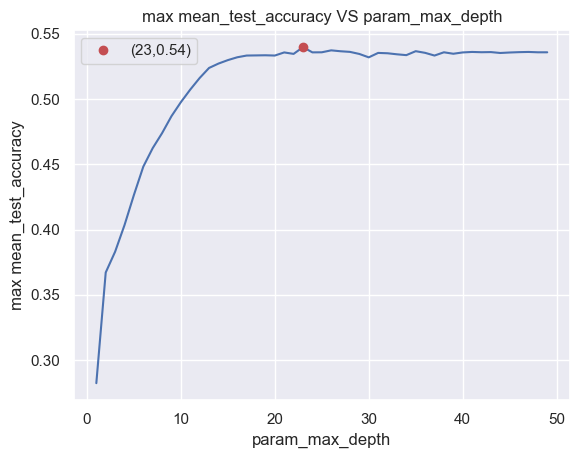

Elapsed Fit Time: 215.54314994812012 [s]


In [46]:
param_grid = {
    'max_depth': np.arange(1,50),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best max_depth is 8. <br>

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the forest, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)
max_depth_vec = []

for random_state in random_state_vec:
    param_grid = {
        'max_depth': np.arange(5,15),
        'random_state': [random_state]
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    max_depth_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_max_depth'].values[0])

In [ ]:
plt.stem(random_state_vec, max_depth_vec)
plt.xlabel('random_state')
plt.ylabel('best max_depth')

In [ ]:
# best values of the feature and their frequency
unique, counts = np.unique(max_depth_vec, return_counts=True)
print(np.asarray((unique, counts)).T)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see after the validation, the best max_depth varies. <br>
In the Exhaustive Search we will include [11, 13, 14].

<b>5. min_samples_split</b><br>

The minimum number of samples required to split an internal node. <br>
High value of min_samples_split means less frequent splits which could reduce overfitting, however too high value can lower the accuracy.

Fitting 5 folds for each of 398 candidates, totalling 1990 fits


,param_min_samples_split,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
2,4,0,18.669322,0.088033,0.537956,0.004785,1
1,3,0,18.991212,0.143148,0.536842,0.007553,2
5,7,0,17.713226,0.060112,0.535993,0.006864,3
0,2,0,19.065848,0.100081,0.535940,0.007148,4
4,6,0,17.899085,0.075390,0.535621,0.005398,5


Best Estimator is: RandomForestClassifier(min_samples_split=4, random_state=0)



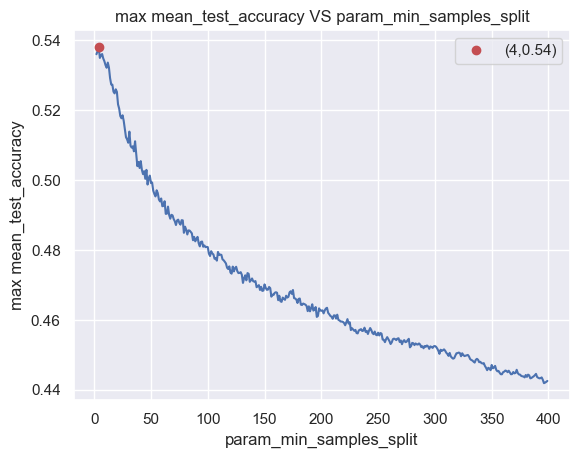

Elapsed Fit Time: 1000.6431171894073 [s]


In [47]:
param_grid = {
    'min_samples_split': np.arange(2,400,1),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best min_samples_split is 3. <br>
In addition, we can see that for as the value of min_samples_split increases the accuracy decreases.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)
min_samples_split_vec = []

for random_state in random_state_vec:
    param_grid = {
        'min_samples_split': [3, 20, 12, 11, 25],
        'random_state': [random_state]
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    min_samples_split_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_min_samples_split'].values[0])

In [ ]:
plt.stem(random_state_vec, min_samples_split_vec)
plt.xlabel('random_state')
plt.ylabel('best min_samples_split')

In [ ]:
# best values of the feature and their frequency
unique, counts = np.unique(min_samples_split_vec, return_counts=True)
print(np.asarray((unique, counts)).T)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best values of min_samples_split varies. <br>
In the Exhaustive Search, we will check [3, 20].

<b>6. min_samples_leaf</b><br>

The minimum number of samples required to be at a leaf node. <br>
It focuses on the minimum number of samples allowed at a leaf node (terminal node) of the tree.
High value of min_samples_leaf means bigger leafs which could reduce overfitting, however too high value can lower the accuracy.

Fitting 5 folds for each of 398 candidates, totalling 1990 fits


,param_min_samples_leaf,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,2,0,17.818933,0.122095,0.535516,0.005876,1
1,3,0,16.665610,0.071668,0.533341,0.005318,2
2,4,0,15.734514,0.081776,0.528301,0.006640,3
3,5,0,14.943255,0.091676,0.524270,0.004017,4
4,6,0,14.494763,0.091844,0.523633,0.006540,5


Best Estimator is: RandomForestClassifier(min_samples_leaf=2, random_state=0)



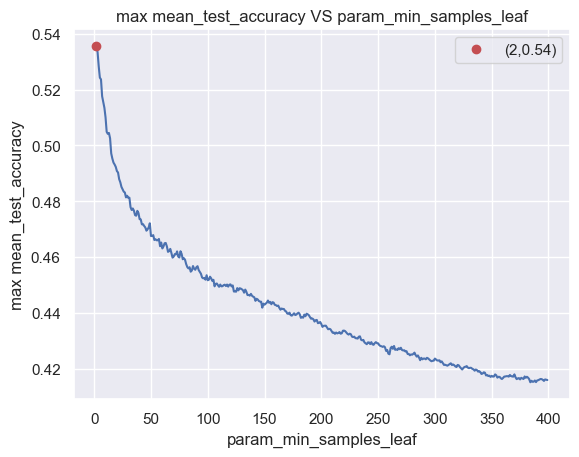

Elapsed Fit Time: 647.6681232452393 [s]


In [48]:
param_grid = {
    'min_samples_leaf': np.arange(2,400),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,param_min_samples_leaf,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,1,0,14.421676,0.034381,0.535940,0.007148,1
1,2,0,13.464497,0.075082,0.535516,0.005876,2


Best Estimator is: RandomForestClassifier(random_state=0)



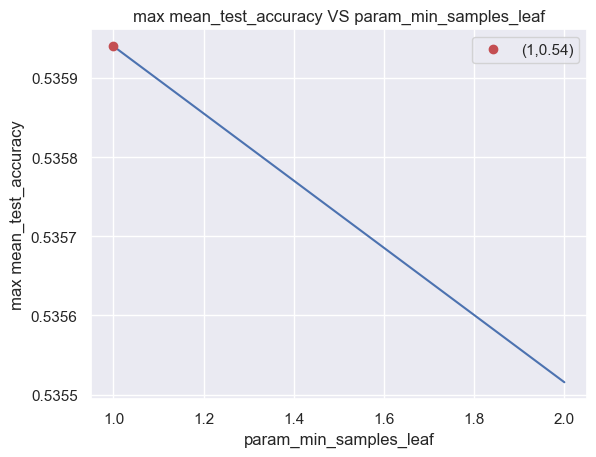

Elapsed Fit Time: 31.96796202659607 [s]


In [51]:
param_grid = {
    'min_samples_leaf': np.arange(1,3),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best min_samples_leaf is 5. <br>
In addition, as min_samples_leaf increases the accuracy decreases.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)
min_samples_leaf_vec = []

for random_state in random_state_vec:
    param_grid = {
        'min_samples_leaf': [5, 4, 9, 26, 6],
        'random_state': [random_state]
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    min_samples_leaf_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_min_samples_leaf'].values[0])

In [ ]:
plt.stem(random_state_vec, min_samples_leaf_vec)
plt.xlabel('random_state')
plt.ylabel('best min_samples_leaf')

In [ ]:
# best values of the feature and their frequency
unique, counts = np.unique(min_samples_leaf_vec, return_counts=True)
print(np.asarray((unique, counts)).T)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, after validation, the best min_samples_leaf varies. <br>
In the Exhaustive Search we will search [4, 5].

<b>7. min_weight_fraction_leaf</b><br>

The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. <br>
Samples have equal weight when sample_weight is not provided. <br>
We will not use this parameter in our evaluation.

<b>8. max_features</b><br>

The parameter max_features is the number of features to consider when looking for the best split. <br>
Influences how the model selects features for splitting at each node in the trees. <br>
Depend on the correlation between features. If features are highly correlated, using a lower value might be sufficient. <br>
Higher value of max_features could give higher accuracy while risking overfitting, and lower value of max_features could reduce overfitting.

Fitting 5 folds for each of 134 candidates, totalling 670 fits


,param_max_features,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
22,24,0,39.221885,0.071388,0.540449,0.003562,1
64,66,0,105.393213,0.452961,0.540078,0.004665,2
90,92,0,136.823885,0.534531,0.539972,0.004883,3
74,76,0,118.196990,0.379299,0.539971,0.005941,4
95,97,0,144.527692,0.631771,0.539812,0.004440,5


Best Estimator is: RandomForestClassifier(max_features=24, random_state=0)



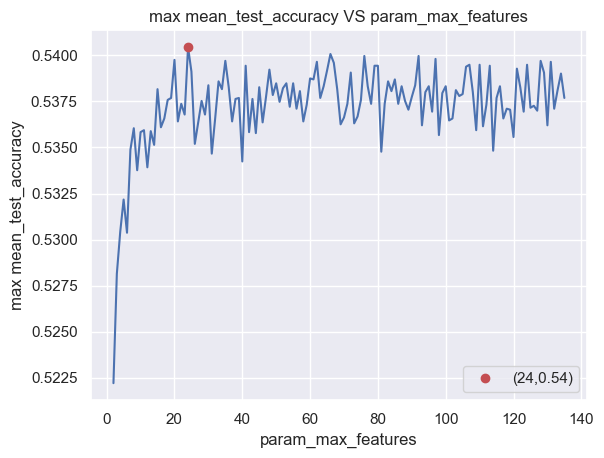

Elapsed Fit Time: 3634.628256082535 [s]


In [49]:
param_grid = {
    'max_features': np.arange(2,136),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the max_features is 32. <br>

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)

acc_32_vec = []
acc_21_vec = []
acc_81_vec = []
acc_12_vec = []
acc_16_vec = []
results_df_i = pd.DataFrame()
for i in random_state_vec:
    
    param_grid = {
    'max_features': [32, 21, 81, 12, 16],
    'random_state': [i]
    }
    
    [results_df,_,_] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    results_df_i = results_df_i.append(results_df.sort_values(by='rank_test_accuracy').iloc[[0]])
    acc_32_vec.append(results_df[results_df['param_max_features']==32]['mean_test_accuracy'].values[0])
    acc_21_vec.append(results_df[results_df['param_max_features']==21]['mean_test_accuracy'].values[0])
    acc_81_vec.append(results_df[results_df['param_max_features']==81]['mean_test_accuracy'].values[0]) 
    acc_12_vec.append(results_df[results_df['param_max_features']==12]['mean_test_accuracy'].values[0])
    acc_16_vec.append(results_df[results_df['param_max_features']==16]['mean_test_accuracy'].values[0])     

In [ ]:
results_df_i['param_max_features'].value_counts()

In [ ]:
# plot the tree runs
plt.plot(random_state_vec, acc_16_vec, label='max_features=16 accuracy, mean = ' + str(round(np.mean(acc_16_vec),3)) +
                                             ' , std = ' + str(round(np.std(acc_16_vec),3)))
plt.plot(random_state_vec, acc_12_vec, label='max_features=12 accuracy, mean = ' + str(round(np.mean(acc_12_vec),3)) +
                                             ' , std = ' + str(round(np.std(acc_12_vec),3)))
plt.plot(random_state_vec, acc_32_vec, label='max_features=32 accuracy, mean = ' + str(round(np.mean(acc_32_vec),3)) + 
                                             ' , std = ' + str(round(np.std(acc_32_vec),3)))
plt.xlabel('random_state')
plt.ylabel('mean_test_accuracy')
plt.ylim([0, 1])
plt.legend()

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the max_features values are stable. <br>
The max_features values that prevail are 16 and 12 according to their consistency as shown in value_counts(). <br>
We will use them when we Exhaustive Search as well as 32.

<b>9. max_leaf_nodes</b><br>

The max_leaf_nodes parameter sets a limit on the maximum number of leaf nodes the tree can have. Leaf nodes are the terminal nodes where final classifications or predictions are made. <br>
Higher value of max_leaf_nodes can lead to overfitting, while lower value of max_leaf_nodes could reduce overfitting.

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


,param_max_leaf_nodes,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
447,449,0,11.196745,0.261508,0.501353,0.005220,1
440,442,0,12.587244,0.044022,0.501300,0.005472,2
446,448,0,11.842318,0.240513,0.501300,0.005008,3
443,445,0,12.563982,0.020968,0.501247,0.005063,4
441,443,0,12.544316,0.040966,0.501141,0.005242,5


Best Estimator is: RandomForestClassifier(max_leaf_nodes=449, random_state=0)



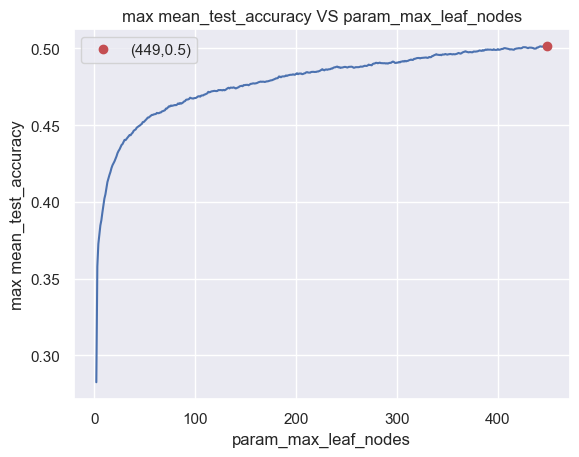

Elapsed Fit Time: 1172.2021732330322 [s]


In [50]:
param_grid = {
    'max_leaf_nodes': np.arange(2,450).tolist(),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

Fitting 5 folds for each of 55 candidates, totalling 275 fits


,param_max_leaf_nodes,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
54,990,0,13.236904,0.050698,0.520344,0.004570,1
53,980,0,13.373132,0.067367,0.520291,0.004233,2
50,950,0,14.373552,0.035467,0.520079,0.003041,3
52,970,0,13.401845,0.059862,0.519867,0.004170,4
51,960,0,14.415963,0.028992,0.519867,0.003883,5


Best Estimator is: RandomForestClassifier(max_leaf_nodes=990, random_state=0)



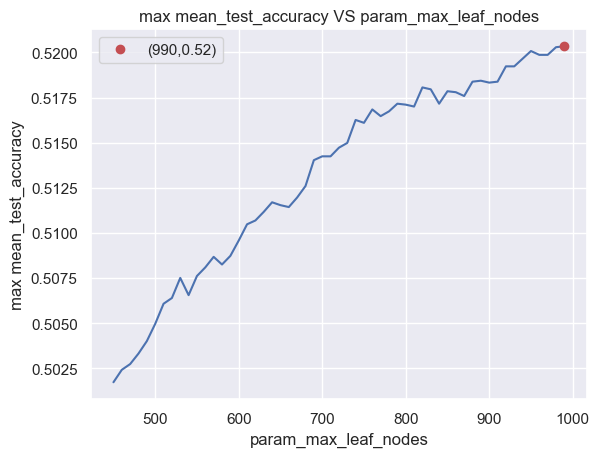

Elapsed Fit Time: 205.18966722488403 [s]


In [54]:
param_grid = {
    'max_leaf_nodes': np.arange(450,1000, 10).tolist(),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,param_max_leaf_nodes,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
79,1790,0,16.415087,0.038143,0.532439,0.005280,1
81,1810,0,16.401285,0.022496,0.532227,0.005514,2
75,1750,0,16.252044,0.018605,0.532068,0.006093,3
76,1760,0,16.355074,0.069866,0.531908,0.005253,4
91,1910,0,16.521375,0.026528,0.531802,0.005228,5


Best Estimator is: RandomForestClassifier(max_leaf_nodes=1790, random_state=0)



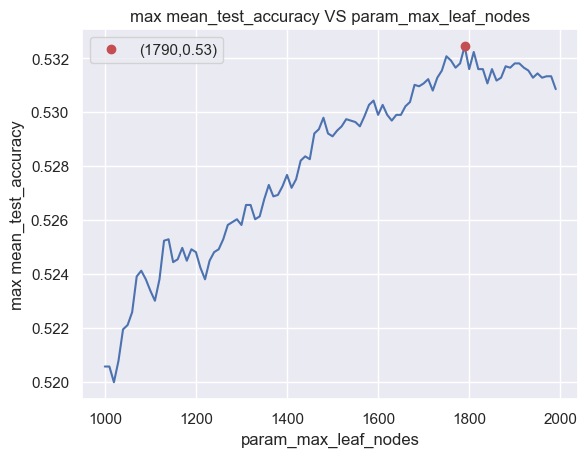

Elapsed Fit Time: 411.6651360988617 [s]


In [55]:
param_grid = {
    'max_leaf_nodes': np.arange(1000,2000, 10).tolist(),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,param_max_leaf_nodes,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
32,2320,0,16.923019,0.043467,0.534667,0.004840,1
98,2980,0,17.137369,0.042137,0.534667,0.004808,2
31,2310,0,17.173858,0.075491,0.534402,0.004845,3
99,2990,0,17.045951,0.088754,0.534402,0.004765,4
97,2970,0,17.211682,0.053973,0.534349,0.004776,5


Best Estimator is: RandomForestClassifier(max_leaf_nodes=2320, random_state=0)



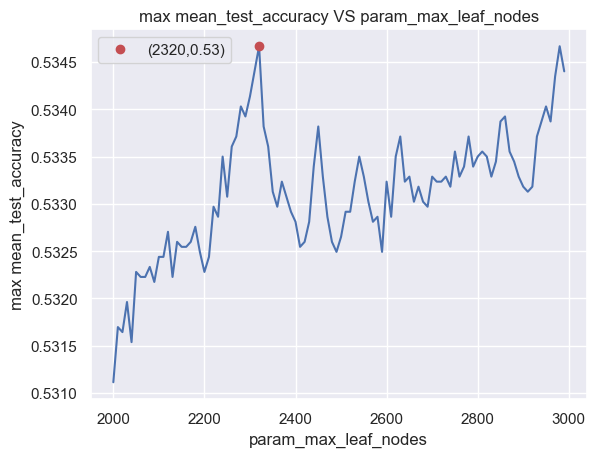

Elapsed Fit Time: 445.8503704071045 [s]


In [60]:
param_grid = {
    'max_leaf_nodes': np.arange(2000,3000, 10).tolist(),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best max_leaf_nodes is 390.<br>
Trees with a lower max_leaf_nodes value will be shallower, as they stop growing once it hits the leaf node limit. We can see in the graph that for lower values of max_leaf_nodes, the performance is worse.<br>

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)
max_leaf_nodes_vec = []

for random_state in random_state_vec:
    param_grid = {
        'max_leaf_nodes': [392, 397, 393, 394, 345],
        'random_state': [random_state]
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    max_leaf_nodes_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_max_leaf_nodes'].values[0])

In [ ]:
plt.stem(random_state_vec, max_leaf_nodes_vec)
plt.xlabel('random_state')
plt.ylabel('best max_leaf_nodes')

In [ ]:
# best values of the feature and their frequency
unique, counts = np.unique(max_leaf_nodes_vec, return_counts=True)
print(np.asarray((unique, counts)).T)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best max_leaf_nodes varies.<br>
In the Exhaustive Search we will use [345, 392].

<b>10. min_impurity_decrease</b><br>

This parameter sets a minimum threshold for the acceptable decrease in impurity when making a split. <br>
It prevents the trees from making unnecessary splits that don't significantly improve the purity of the child nodes. <br>
We will not evaluate this parameter in our search. <br>

Fitting 5 folds for each of 11 candidates, totalling 55 fits


,param_min_impurity_decrease,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.0,0,14.705904,0.046523,0.535940,0.007148,1
1,0.1,0,1.259483,0.032549,0.282425,0.000103,2
2,0.2,0,1.234677,0.014641,0.282425,0.000103,2
3,0.3,0,1.252280,0.036273,0.282425,0.000103,2
4,0.4,0,1.156060,0.004491,0.282425,0.000103,2
5,0.5,0,1.155659,0.004129,0.282425,0.000103,2
6,0.6,0,1.158862,0.004499,0.282425,0.000103,2
7,0.7,0,1.216673,0.044284,0.282425,0.000103,2
8,0.8,0,1.214473,0.018950,0.282425,0.000103,2
9,0.9,0,1.224075,0.036693,0.282425,0.000103,2


Best Estimator is: RandomForestClassifier(random_state=0)



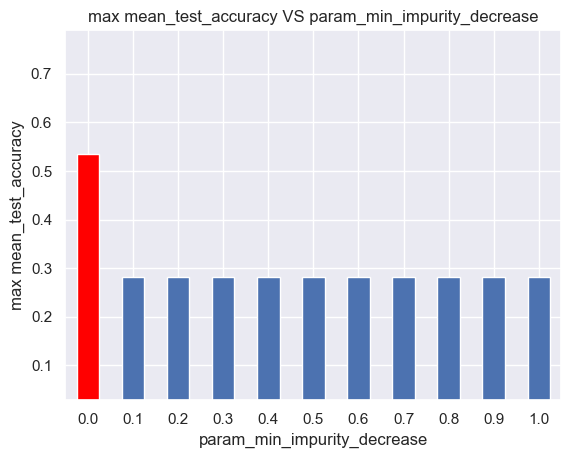

Elapsed Fit Time: 32.06168246269226 [s]


In [56]:
param_grid = {
    'min_impurity_decrease': np.round(np.arange(0,1.1, 0.1),2),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best min_impurity_decrease is the default 0.<br>
Therefore, we will not change its default value.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)
min_impurity_decrease_vec = []

for random_state in random_state_vec:
    param_grid = {
        'min_impurity_decrease': np.round(np.arange(0,1.1, 0.1),2),
        'random_state': [random_state]
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    min_impurity_decrease_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_min_impurity_decrease'].values[0])

In [ ]:
plt.plot(random_state_vec, min_impurity_decrease_vec)
plt.xlabel('random_state')
plt.ylabel('best min_impurity_decrease')

In [ ]:
# best values of the feature
np.unique(min_impurity_decrease_vec)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best min_impurity_decrease is the default 0, even for different random_states.<br>
Therefore, we will not change its default value.

<b>11. bootstrap</b><br>

Whether bootstrap samples are used when building trees. If false, the whole dataset is used to build each tree. <br>

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,param_bootstrap,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
1,False,0,21.985738,0.098450,0.540131,0.005789,1
0,True,0,14.453046,0.147814,0.535940,0.007148,2


Best Estimator is: RandomForestClassifier(bootstrap=False, random_state=0)



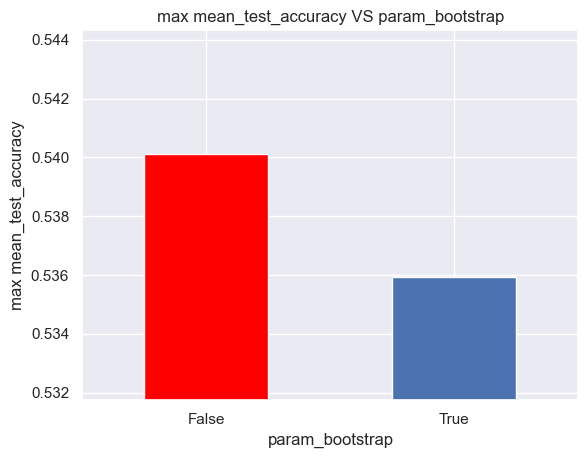

Elapsed Fit Time: 48.68744087219238 [s]


In [57]:
param_grid = {
    'bootstrap': [True, False],
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the criterion does not significantly improves the performance. <br>

<u>Validation</u>:<br>
We will iterate through 100 different random_states of the forest, in order to validate the results we got above.

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'random_state': np.arange(100)
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])

In [ ]:
# extract from the results the runs mean_test_accuracy for each strategy vs the random_state
true_vec_df = results_df[results_df['param_bootstrap']==True][['param_random_state', 'mean_test_accuracy']]
false_vec_df = results_df[results_df['param_bootstrap']==False][['param_random_state', 'mean_test_accuracy']]

In [ ]:
# plot both of the runs
plt.plot(true_vec_df[['param_random_state']].values, true_vec_df[['mean_test_accuracy']].values, label='true bootstrap')
plt.plot(false_vec_df[['param_random_state']].values, false_vec_df[['mean_test_accuracy']].values, label='false bootstrap')
plt.xlabel('bootstrap')
plt.ylabel('mean_test_accuracy')
plt.legend()

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the bootstrap varies. <br>
In the Exhaustive Search, we will use the default value True because the difference between them is slim.

<b>12. oob_score</b><br>
Whether to use Out-Of-Bag samples to estimate the generalization score. <br>
This parameter will not impact the accuracy of the classifier, therefore we will not evaluate it in our search.

<b>13. n_jobs</b><br>
The number of jobs to run in parallel. <br>
This parameter will not impact the accuracy of the classifier, therefore we will not evaluate it in our search.

<b>14. verbose</b><br>
Controls the verbosity when fitting and predicting. <br>
This parameter will not impact the accuracy of the classifier, therefore we will not evaluate it in our search.

<b>15. warm_start</b><br>
When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest. <br>

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,param_warm_start,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,True,0,14.535064,0.169006,0.53594,0.007148,1
1,False,0,14.402235,0.170156,0.53594,0.007148,1


Best Estimator is: RandomForestClassifier(random_state=0, warm_start=True)



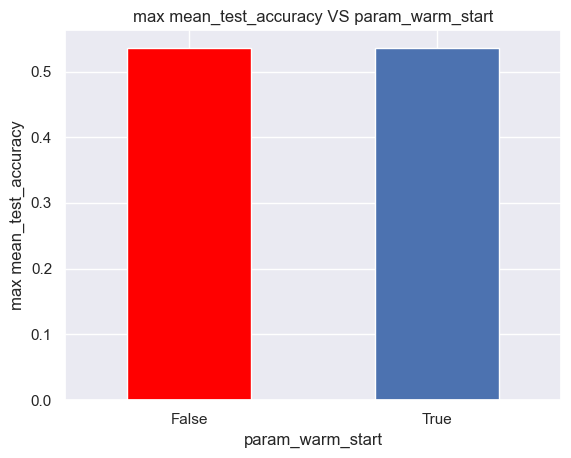

Elapsed Fit Time: 32.03738069534302 [s]


In [58]:
param_grid = {
    'warm_start': [True, False],
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the criterion does not improve the performance. <br>

<u>Validation</u>:<br>
We will iterate through 100 different random_states of the forest, in order to validate the results we got above.

In [ ]:
param_grid = {
    'warm_start': [True, False],
    'random_state': np.arange(100)
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])

In [ ]:
# extract from the results the runs mean_test_accuracy for each strategy vs the random_state
true_vec_df = results_df[results_df['param_warm_start']==True][['param_random_state', 'mean_test_accuracy']]
false_vec_df = results_df[results_df['param_warm_start']==False][['param_random_state', 'mean_test_accuracy']]

In [ ]:
# plot both of the runs
plt.plot(true_vec_df[['param_random_state']].values, true_vec_df[['mean_test_accuracy']].values, label='true warm_start')
plt.plot(false_vec_df[['param_random_state']].values, false_vec_df[['mean_test_accuracy']].values, '--' ,label='false warm_start')
plt.xlabel('warm_start')
plt.ylabel('mean_test_accuracy')
plt.legend()

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, modfying the warm_start does not improve the performance. <br>
Therefore, we will use the default value True.

<b>16. class_weight</b><br>
Weights associated with classes. <br>
We will not evaluate this parameter in our search.

<b>17. ccp_alpha</b><br>
The parameter CCP aims to find a simpler subtree within the fully grown tree that offers a good balance between accuracy and complexity. <br>

Fitting 5 folds for each of 11 candidates, totalling 55 fits


,param_ccp_alpha,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.0,0,17.588566,0.038871,0.535940,0.007148,1
1,0.1,0,20.198753,0.034239,0.282425,0.000103,2
2,0.2,0,20.201152,0.096378,0.282425,0.000103,2
3,0.3,0,20.175548,0.103861,0.282425,0.000103,2
4,0.4,0,20.071740,0.030532,0.282425,0.000103,2
5,0.5,0,20.119151,0.065667,0.282425,0.000103,2
6,0.6,0,20.080354,0.073448,0.282425,0.000103,2
7,0.7,0,20.107549,0.081630,0.282425,0.000103,2
8,0.8,0,18.814644,0.058746,0.282425,0.000103,2
9,0.9,0,18.280724,0.063841,0.282425,0.000103,2


Best Estimator is: RandomForestClassifier(random_state=0)



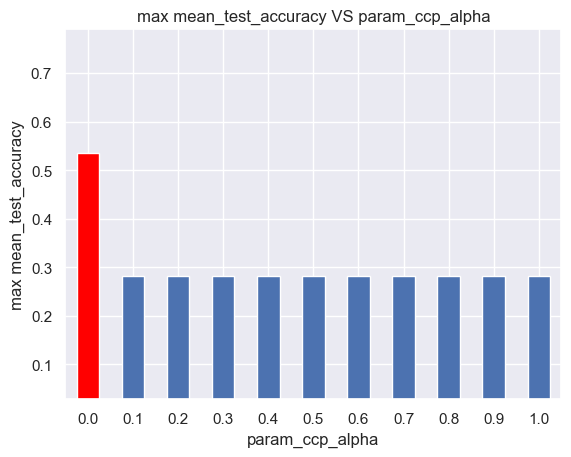

Elapsed Fit Time: 75.89204239845276 [s]


In [59]:
param_grid = {
    'ccp_alpha': np.round(np.arange(0,1.1, 0.1),2),
    'random_state': [0]
}

[results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'plot', 'time'])

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, for this run the best ccp_alpha is the default 0.<br>
Therefore, we will not change its default value.

<u>Validation</u>:<br>
We will iterate through 30 different random_states of the tree, in order to validate the results we got above.

In [ ]:
random_state_vec = np.arange(30)
ccp_alpha_vec = []

for random_state in random_state_vec:
    param_grid = {
        'ccp_alpha': np.round(np.arange(0,1.1, 0.1),2),
        'random_state': [random_state]
    }

    [results_df, best_estimator, clf_fitted] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=[])
    ccp_alpha_vec.append(results_df[results_df['rank_test_accuracy']==1]['param_ccp_alpha'].values[0])

In [ ]:
plt.plot(random_state_vec, ccp_alpha_vec)
plt.xlabel('random_state')
plt.ylabel('best ccp_alpha')

In [ ]:
# best values of the feature
np.unique(ccp_alpha_vec)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
As we can see, the best ccp_alpha is the default 0, even for different random_states.<br>
Therefore, we will not change its default value.

<b>18. max_samples</b><br>
If bootstrap is True, the number of samples to draw from X to train each base estimator. <br>
If set to None, it will use the number of samples in the train. <br>
We will not evaluate this parameter in our search.

<h3>Exhaustive Search:</h3>

When evaluating different parameters, combinations of values of different parameters can influence on the performance of the classifiers. <br>
We assume, that the improvement of the accuracy won't be so significant so due to limitations of time and resources we only check the combinations of the best values of each parameter.

In [62]:
param_grid = {    
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 23, 50],
    'min_samples_split': [4, 7],
    'min_samples_leaf': [2, 3],
    'max_features': [136, 68, 12],
    'max_leaf_nodes': [500, 1000, 1500, 1790, 2320, 2980, 3000],
    'bootstrap': [True, False],
    'random_state': [0]
}

[results_df_RF, best_estimator_RF, clf_fitted_RF] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 3024 candidates, totalling 15120 fits


In [28]:
param_grid = {    
    'n_estimators': [100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 23, 50],
    'min_samples_split': [4, 7],
    'min_samples_leaf': [2, 3],
    'max_features': [136, 68, 12],
    'max_leaf_nodes': [2320],
    'bootstrap': [True, False],
    'random_state': [0]
}

[results_df_RF, best_estimator_RF, clf_fitted_RF] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 144 candidates, totalling 720 fits


,param_n_estimators,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_leaf_nodes,param_bootstrap,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
28,100,gini,50,4,2,68,2320,True,0,94.725054,0.456879,0.541245,0.007039,1
16,100,gini,23,4,2,68,2320,True,0,93.710924,0.461487,0.540502,0.006896,2
95,100,gini,23,7,3,12,2320,False,0,25.011507,0.051676,0.540290,0.002177,3
93,100,gini,23,7,2,12,2320,False,0,25.811418,0.063279,0.540025,0.005385,4
17,100,gini,23,7,2,68,2320,True,0,92.154042,0.353502,0.539812,0.004449,5


Best Estimator is: RandomForestClassifier(max_depth=50, max_features=68, max_leaf_nodes=2320,
                       min_samples_leaf=2, min_samples_split=4, random_state=0)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,188,0,28,126,173,72,27
disgust,9,24,2,17,15,9,4
fear,60,0,122,97,184,84,71
happy,24,0,20,1117,98,33,21
neutral,32,0,24,75,630,101,12
sad,54,1,22,95,270,181,14
surprise,10,0,24,66,66,26,363




The Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.31      0.38       614
     disgust       0.96      0.30      0.46        80
        fear       0.50      0.20      0.28       618
       happy       0.70      0.85      0.77      1313
     neutral       0.44      0.72      0.55       874
         sad       0.36      0.28      0.32       637
    surprise       0.71      0.65      0.68       555

    accuracy                           0.56      4691
   macro avg       0.60      0.47      0.49      4691
weighted avg       0.56      0.56      0.54      4691



Elapsed Fit Time: 6129.891601800919 [s]


In [29]:
param_grid = {    
    'n_estimators': [200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 23, 50],
    'min_samples_split': [4, 7],
    'min_samples_leaf': [2, 3],
    'max_features': [136, 68, 12],
    'max_leaf_nodes': [2320],
    'bootstrap': [True, False],
    'random_state': [0]
}

[results_df_RF, best_estimator_RF, clf_fitted_RF] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 144 candidates, totalling 720 fits


,param_n_estimators,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_leaf_nodes,param_bootstrap,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
93,200,gini,23,7,2,12,2320,False,0,50.278440,0.072483,0.542677,0.005206,1
28,200,gini,50,4,2,68,2320,True,0,189.314372,0.835351,0.541828,0.004950,2
16,200,gini,23,4,2,68,2320,True,0,186.869015,0.670965,0.541510,0.004688,3
92,200,gini,23,4,2,12,2320,False,0,50.167216,0.101743,0.541086,0.004326,4
105,200,gini,50,7,2,12,2320,False,0,50.498892,0.073022,0.541086,0.005994,5


Best Estimator is: RandomForestClassifier(bootstrap=False, max_depth=23, max_features=12,
                       max_leaf_nodes=2320, min_samples_leaf=2,
                       min_samples_split=7, n_estimators=200, random_state=0)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,183,0,16,138,190,63,24
disgust,10,23,1,16,16,8,6
fear,43,0,112,118,192,78,75
happy,26,0,9,1138,92,30,18
neutral,36,0,15,68,640,100,15
sad,51,0,21,107,269,174,15
surprise,13,0,17,66,72,15,372




The Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.30      0.38       614
     disgust       1.00      0.29      0.45        80
        fear       0.59      0.18      0.28       618
       happy       0.69      0.87      0.77      1313
     neutral       0.44      0.73      0.55       874
         sad       0.37      0.27      0.31       637
    surprise       0.71      0.67      0.69       555

    accuracy                           0.56      4691
   macro avg       0.61      0.47      0.49      4691
weighted avg       0.57      0.56      0.53      4691



Elapsed Fit Time: 12037.52901339531 [s]


In [30]:
param_grid = {    
    'n_estimators': [500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [14, 23, 50],
    'min_samples_split': [4, 7],
    'min_samples_leaf': [2, 3],
    'max_features': [136, 68, 12],
    'max_leaf_nodes': [2320],
    'bootstrap': [True, False],
    'random_state': [0]
}

[results_df_RF, best_estimator_RF, clf_fitted_RF] = eval_classifier(base_estimator_RF, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 144 candidates, totalling 720 fits


,param_n_estimators,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_leaf_nodes,param_bootstrap,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
12,500,gini,23,4,2,136,2320,True,0,945.289029,3.162820,0.541934,0.003548,1
29,500,gini,50,7,2,68,2320,True,0,473.232359,1.849883,0.541775,0.004748,2
16,500,gini,23,4,2,68,2320,True,0,480.435220,1.527380,0.541775,0.003613,3
64,500,entropy,50,4,2,68,2320,True,0,852.798606,1.417685,0.541775,0.004012,4
92,500,gini,23,4,2,12,2320,False,0,129.381326,0.275337,0.541457,0.003220,5


Best Estimator is: RandomForestClassifier(max_depth=23, max_features=136, max_leaf_nodes=2320,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, random_state=0)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,200,0,30,106,179,72,27
disgust,9,26,1,14,19,4,7
fear,59,0,116,98,187,88,70
happy,28,0,12,1110,111,34,18
neutral,37,0,20,77,624,103,13
sad,60,0,23,93,277,173,11
surprise,15,0,21,64,67,21,367




The Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.33      0.39       614
     disgust       1.00      0.33      0.49        80
        fear       0.52      0.19      0.28       618
       happy       0.71      0.85      0.77      1313
     neutral       0.43      0.71      0.53       874
         sad       0.35      0.27      0.31       637
    surprise       0.72      0.66      0.69       555

    accuracy                           0.56      4691
   macro avg       0.60      0.48      0.49      4691
weighted avg       0.56      0.56      0.53      4691



Elapsed Fit Time: 31344.28924870491 [s]


In [ ]:
eval_best(best_estimator_RF, base_estimator_RF, X_train, X_test, y_train, y_test, Labels, n_jobs)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
In order to make sure that our decision decided optimal classifier does represent well the true optimal classifier, so we conducted model validation by testing the best classifier on different test and train dataset divisions (test_size), and on different dataset shuffles (random_state). <br>
As we can see, the model validation is stable.

In [ ]:
# end timer for full classifier evaluation run
elapsed_classifier = time() - t_classifier
print("Elapsed Full Classifier Evaluation Time: " + str(elapsed_classifier) + " [s]")

<a id="Random_Forest_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>Random Forest Overall Conclusion:</u></h2><br>
In this section, we tested the performance of Random Forest algorithm on our dataset. <br>
We went over possible parameters of the classifier, and checked their influence on the performance. <br>

Our choose for the best Random Forest classifier is: RandomForestClassifier(criterion='entropy', max_depth=14, max_features=12,
                       max_leaf_nodes=345, min_samples_leaf=5,
                       min_samples_split=3, n_estimators=445, random_state=0) which brings accuracy of 0.76 and an f1 score of 0.76.<br>

<a id="XGBoost"></a>
<h1>XGBoost</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

[
]

In [64]:
# start timer for full classifier evaluation run
t_classifier = time()

<h3>Params Search:</h3>

In [66]:
from xgboost import XGBClassifier

base_estimator_xgboost = XGBClassifier()
base_estimator_xgboost.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

<h4>The params are:</h4>

<h3>Exhaustive Search:</h3>

When evaluating different parameters, combinations of values of different parameters can influence on the performance of the classifiers. <br>
We assume, that the improvement of the accuracy won't be so significant so due to limitations of time and resources we only check the combinations of the best values of each parameter.

In [72]:
param_grid = {
    'random_state': [0]
}

[results_df_xgboost, best_estimator_xgboost, clf_fitted_xgboost] = eval_classifier(base_estimator_xgboost, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,param_random_state,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0,19.070471,0.243111,0.557689,0.005705,1


Best Estimator is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,256,0,54,68,133,79,24
disgust,14,29,5,9,12,6,5
fear,82,0,153,68,161,80,74
happy,22,0,35,1114,86,36,20
neutral,73,0,46,63,562,114,16
sad,72,0,54,76,247,171,17
surprise,21,0,45,48,38,18,385




The Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.42      0.44       614
     disgust       1.00      0.36      0.53        80
        fear       0.39      0.25      0.30       618
       happy       0.77      0.85      0.81      1313
     neutral       0.45      0.64      0.53       874
         sad       0.34      0.27      0.30       637
    surprise       0.71      0.69      0.70       555

    accuracy                           0.57      4691
   macro avg       0.59      0.50      0.52      4691
weighted avg       0.56      0.57      0.56      4691



Elapsed Fit Time: 26.30281400680542 [s]


In [68]:
param_grid = {
    'n_estimators': [50],               # Number of boosting rounds
    'max_depth': [3],                       # Maximum depth of the tree
    'learning_rate': [0.01],            # Learning rate (shrinkage)
    'subsample': [0.6],                 # Subsample ratio of the training instances
    'colsample_bytree': [0.6],          # Subsample ratio of columns when constructing each tree
    'gamma': [0.1],
    'reg_alpha': [0.01],                  # L1 regularization term on weights
    'reg_lambda': [0.1]                  # L2 regularization term on weights
}

[results_df_xgboost, best_estimator_xgboost, clf_fitted_xgboost] = eval_classifier(base_estimator_xgboost, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,param_gamma,param_reg_alpha,param_reg_lambda,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,50,3,0.01,0.6,0.6,0.1,0.01,0.1,4.233812,0.097727,0.448199,0.007008,1


Best Estimator is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,75,0,7,214,228,31,59
disgust,10,0,4,24,28,5,9
fear,34,0,16,197,257,40,74
happy,15,0,5,1125,125,10,33
neutral,15,0,4,195,604,37,19
sad,26,0,7,184,343,49,28
surprise,15,0,25,130,127,14,244




The Classification Report:
              precision    recall  f1-score   support

       angry       0.39      0.12      0.19       614
     disgust       0.00      0.00      0.00        80
        fear       0.24      0.03      0.05       618
       happy       0.54      0.86      0.67      1313
     neutral       0.35      0.69      0.47       874
         sad       0.26      0.08      0.12       637
    surprise       0.52      0.44      0.48       555

    accuracy                           0.45      4691
   macro avg       0.33      0.32      0.28      4691
weighted avg       0.40      0.45      0.38      4691



Elapsed Fit Time: 7.464165925979614 [s]


d:\Yakir\Development\Python\FaceRecognition\Research\landmarks_research2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Yakir\Development\Python\FaceRecognition\Research\landmarks_research2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Yakir\Development\Python\FaceRecognition\Research\landmarks_research2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

In [69]:
param_grid = {
    'n_estimators': [50],               # Number of boosting rounds
    'max_depth': [3, 5, 7],                       # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],            # Learning rate (shrinkage)
    'subsample': [0.6, 0.8, 1.0],                 # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],          # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],                  # L1 regularization term on weights
    'reg_lambda': [1, 0.1, 0.01]                  # L2 regularization term on weights
}

[results_df_xgboost, best_estimator_xgboost, clf_fitted_xgboost] = eval_classifier(base_estimator_xgboost, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,param_gamma,param_reg_alpha,param_reg_lambda,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
968,50,7,0.2,1.0,0.8,0,0.1,0.1,34.991912,0.284665,0.558803,0.006362,1
476,50,7,0.2,1.0,0.6,0.1,0.01,0.01,34.372676,0.387903,0.558061,0.005103,2
230,50,7,0.2,1.0,0.6,0,0.01,0.1,35.084739,0.478840,0.558061,0.004821,3
1451,50,7,0.2,1.0,0.8,0.2,0.1,1,37.792011,0.607306,0.557796,0.006563,4
461,50,7,0.2,1.0,0.6,0.1,0,1,35.262056,0.391409,0.557636,0.004211,5


Best Estimator is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,233,0,44,84,141,86,26
disgust,14,27,6,12,13,6,2
fear,64,0,111,83,186,91,83
happy,26,0,23,1125,82,38,19
neutral,60,0,30,57,595,119,13
sad,81,0,32,87,266,155,16
surprise,21,0,32,51,50,18,383




The Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.38      0.42       614
     disgust       1.00      0.34      0.50        80
        fear       0.40      0.18      0.25       618
       happy       0.75      0.86      0.80      1313
     neutral       0.45      0.68      0.54       874
         sad       0.30      0.24      0.27       637
    surprise       0.71      0.69      0.70       555

    accuracy                           0.56      4691
   macro avg       0.58      0.48      0.50      4691
weighted avg       0.55      0.56      0.54      4691



Elapsed Fit Time: 10413.082891225815 [s]


In [70]:
param_grid = {
    'n_estimators': [50, 100, 150, 300],               # Number of boosting rounds
    'max_depth': [7, 15, 30, 60],                       # Maximum depth of the tree
    'learning_rate': [0.2],            # Learning rate (shrinkage)
    'subsample': [1.0],                 # Subsample ratio of the training instances
    'colsample_bytree': [0.8],          # Subsample ratio of columns when constructing each tree
    'gamma': [0],
    'reg_alpha': [0.1],                  # L1 regularization term on weights
    'reg_lambda': [0.1]                  # L2 regularization term on weights
}

[results_df_xgboost, best_estimator_xgboost, clf_fitted_xgboost] = eval_classifier(base_estimator_xgboost, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,param_gamma,param_reg_alpha,param_reg_lambda,mean_fit_time,std_fit_time,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3,300,7,0.2,1.0,0.8,0,0.1,0.1,200.797298,1.641857,0.565063,0.004085,1
15,300,60,0.2,1.0,0.8,0,0.1,0.1,282.528596,12.852872,0.564745,0.005355,2
2,150,7,0.2,1.0,0.8,0,0.1,0.1,108.356016,1.411100,0.562941,0.004458,3
14,150,60,0.2,1.0,0.8,0,0.1,0.1,326.246303,8.937194,0.562623,0.006142,4
1,100,7,0.2,1.0,0.8,0,0.1,0.1,73.932990,0.417299,0.562357,0.005473,5


Best Estimator is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

The Confusion Matrix:


,angry,disgust,fear,happy,neutral,sad,surprise
angry,251,1,43,75,145,79,20
disgust,16,29,2,12,11,6,4
fear,68,0,144,77,153,99,77
happy,27,0,26,1122,82,32,24
neutral,70,0,35,62,592,102,13
sad,70,1,39,77,263,176,11
surprise,18,0,37,49,46,18,387




The Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.41      0.44       614
     disgust       0.94      0.36      0.52        80
        fear       0.44      0.23      0.31       618
       happy       0.76      0.85      0.81      1313
     neutral       0.46      0.68      0.55       874
         sad       0.34      0.28      0.31       637
    surprise       0.72      0.70      0.71       555

    accuracy                           0.58      4691
   macro avg       0.59      0.50      0.52      4691
weighted avg       0.57      0.58      0.56      4691



Elapsed Fit Time: 1287.2970595359802 [s]


In [67]:
param_grid = {
    'n_estimators': [50, 100, 150],               # Number of boosting rounds
    'max_depth': [3, 5, 7],                       # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],            # Learning rate (shrinkage)
    'subsample': [0.6, 0.8, 1.0],                 # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],          # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],                  # L1 regularization term on weights
    'reg_lambda': [1, 0.1, 0.01]                  # L2 regularization term on weights
}

[results_df_xgboost, best_estimator_xgboost, clf_fitted_xgboost] = eval_classifier(base_estimator_xgboost, param_grid, X_train, X_test, y_train, y_test, Labels, test_size=0.2, random_state=0, n_jobs=n_jobs, is_printing=['best', 'report', 'time'])

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


KeyboardInterrupt: 

In [ ]:
eval_best(best_estimator_xgboost, base_estimator_xgboost, X_train, X_test, y_train, y_test, Labels, n_jobs)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
In order to make sure that our decision decided optimal classifier does represent well the true optimal classifier, so we conducted model validation by testing the best classifier on different test and train dataset divisions (test_size), and on different dataset shuffles (random_state). <br>
As we can see, the model validation is stable.

In [ ]:
# end timer for full classifier evaluation run
elapsed_classifier = time() - t_classifier
print("Elapsed Full Classifier Evaluation Time: " + str(elapsed_classifier) + " [s]")

<a id="Random_Forest_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>Random Forest Overall Conclusion:</u></h2><br>
In this section, we tested the performance of Random Forest algorithm on our dataset. <br>
We went over possible parameters of the classifier, and checked their influence on the performance. <br>

Our choose for the best Random Forest classifier is: RandomForestClassifier(criterion='entropy', max_depth=14, max_features=12,
                       max_leaf_nodes=345, min_samples_leaf=5,
                       min_samples_split=3, n_estimators=445, random_state=0) which brings accuracy of 0.76 and an f1 score of 0.76.<br>

<a id="Part3"></a>
<h1 style='text-align: center'><u style='background-color:rgb(0,255,128)'>Part 3 - Classifiers Comparison</u></h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Back To Top](#TOC)

At Part 2, using the pretrained dataset, we evaluated each classifier algorithm seperately and found the best classifier in terms of accuracy. <br>
Now, we will compare between the best classifiers of each kind, to find the classifier best among them that his predicted accuracy on future examples will be the best feasible.

<h4>load the pretrained dataset</h4>

In [ ]:
#YLabels = np.ravel(pd.read_csv("TextExamples.csv", usecols=['sentiment']))
#X = pd.read_csv("TextPretrainedEmbeddings.csv").values

#Labels, Y = np.unique(YLabels, return_inverse=True)

#X_train, X_test, y_train, y_test = train_test_split(X_train, X_test, y_train, y_test, test_size=0.2, random_state=0)

<h4>init the classifiers</h4>

In [ ]:
KNN_classifier = KNeighborsClassifier(algorithm='ball_tree', leaf_size=60, n_neighbors=63, weights='distance')
QDA_classifier = QuadraticDiscriminantAnalysis(priors=[0.50464237, 0.49535763])
LDA_classifier = LinearDiscriminantAnalysis(priors=[0.52, 0.48], shrinkage=0.05, solver='lsqr')
GNB_classifier = GaussianNB(priors=[0.36, 0.64])
DT_classifier = DecisionTreeClassifier(max_depth=7, max_features=42, max_leaf_nodes=55, min_samples_leaf=87, min_samples_split=63, random_state=0)
RT_classifier = RandomForestClassifier(criterion='entropy', max_depth=14, max_features=12,
                       max_leaf_nodes=345, min_samples_leaf=5,
                       min_samples_split=3, n_estimators=445, random_state=0)

In [ ]:
classifiers = [KNN_classifier, QDA_classifier, LDA_classifier, GNB_classifier, DT_classifier, RT_classifier]

<h4>fit and score the classifiers</h4>

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from time import time

cv_accuracy_vec = []
accuracy_vec = []
f1_negative_vec = []
f1_positive_vec = []
time_vec = []

for clf in classifiers: 
    t = time()
    clf.fit(X_train, y_train)
    time_vec.append(time() - t)
    y_pred = clf.predict(X_test)
    cv_accuracy_vec.append(round(np.mean(cross_val_score(clf, X_train, y_train, cv=5)),3))
    accuracy_vec.append(round(accuracy_score(y_test, y_pred),3))
    f1_negative_vec.append(round(f1_score(y_test, y_pred, average=None)[0],3))
    f1_positive_vec.append(round(f1_score(y_test, y_pred, average=None)[1],3))

In [ ]:
plotdata = pd.DataFrame({

    "accuracy": accuracy_vec,    
    
    "f1 negative": f1_negative_vec,
    
    "f1 positive": f1_positive_vec},
    

    index=["KNN", "QDA", "LDA", "GNB", "DT", "RF"])

In [ ]:
ax = plotdata.plot.bar(figsize=(15, 8), width=0.8, rot=1)
plt.ylim([0, 1])

for container in ax.containers:
    ax.bar_label(container)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
In this graph we can see the accuracy of each classifier, as well as the f1 score for each class. <br>
The classifier who yielded the highest accuracy on unseen data, is the LDA classifier, with an accuracy of 0.805.
However, the decision tree yielded the lowest accuracy on unseen data, with an accuracy of 0.699. <br>
The reason we decided to present the accuracy with f1 score for each class, is to validate the results and make sure there is no bias for error types. <br>

In [ ]:
plotdata_cv = pd.DataFrame({
    
    "mean cv accuracy": cv_accuracy_vec,    

    "accuracy": accuracy_vec},
    

    index=["KNN", "QDA", "LDA", "GNB", "DT", "RF"])

In [ ]:
ax = plotdata_cv.plot.bar(figsize=(15, 8), width=0.8, rot=1)
plt.ylim([0, 1])

for container in ax.containers:
    ax.bar_label(container)

<h3><u style='background-color:yellow'>Conclusion:</u></h3>
In this graph we can see the mean cv accuracy of each classifier, as well as the accuracy. <br>
This comparison is ment to show that the accuracy results are valid, stable and reliable.

<a id="Random_Forest_Conclusion"></a>
<h2 style='text-align: center'><u style='background-color:cyan'>Classifiers Comparison Overall Conclusion:</u></h2><br>
According to the graphs, LDA classifier yields accuracy of 0.805 when predicting unseen data, which yielded the highest accuracy among any other classifier we evaluated, thus surpassing the other classifiers. <br>
In addition, we can see that GNB and DT yields the lowest accuracy.
We assume that the reason for LDA being the best classifier, is because the nature of the data matches the assumptions of LDA.
For e.g., LDA assumes that for each class in the dataset, the covariance matrix is equal, and according to the calculation below we can see that it is true for our dataset.

In [ ]:
cov_matrix_negative = np.cov(X_train[y_train==0],rowvar=False)
cov_matrix_positive = np.cov(X_train[y_train==1],rowvar=False)
cov_diff =cov_matrix_negative-cov_matrix_positive
cov_MSE = np.mean(np.square(cov_diff))
cov_MSE

Additonaly, we can see below the Correlation Matrix between the features of the dataset. <br>
There is some related correlation between the features. <br>
And according to our assumption, that is one of the reasons why LDA performs well, while GNB and DT perform poorly.

In [ ]:
# create the dataframe for the dataset
df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(128)])

# compute correlation matrix
correlation_matrix = df.corr()

# plot correlation matrix
plt.figure()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Features')
plt.show()

<a id="Part3_Conclusions"></a>
We can see in the graph below, that there isn't enough separation between the values of features to distinguish between positive and negative classes. <br>
We assume that it is one of the reasons why the rest of the classifiers have achieved lower performance than the LDA did, and the reason why the Random Forest is the second best classifier, as they are more versetile in choosing the parameters that distinguish the best between the negative and positive classes. <br>

In [ ]:
# mean of the negative and positive
neg_mean = np.mean(X_train[y_train==0],0)
pos_mean = np.mean(X_train[y_train==1],0)

# std of the negative and positive
neg_std = np.std(X_train[y_train==0],0)
pos_std = np.std(X_train[y_train==1],0)

print("mean of std for negative = " + str(np.mean(neg_std)))
print("mean of std for positive = " + str(np.mean(pos_std)))

plt.figure(figsize=(15, 8))
plt.grid(True)
for i in range(128):
    plt.plot([i, i], [neg_mean[i], pos_mean[i]], color='gray')
plt.plot(range(128),neg_mean, 'o')
plt.plot(range(128),pos_mean,'x')